# KiteFAST vs CSIM Post-Processing
## This tool was created by RRD Engineering, LLC for the benefit of Makani Technologies, LLC
## **** If parts of this tool are used elsewhere and/or in publications, please acknowledge the authors and this contribution ****

#### ~/sandbox/glue-codes/kitefast/test_cases/RRD_m600_landbased/
#### ~/makani/logs   

In [174]:
import pandas as pd
from pathlib import Path
import os, sys, datetime
import numpy as np
import h5py
import pylab
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from myrotation import myRotation 
import seaborn as sns
sns.set(style="darkgrid")
import socket
injupyter=hasattr(__builtins__,'__IPYTHON__') #whether or not in jupyter
# from IPython.core.debugger import set_trace  #uncomment here for debugger

## INPUTS

In [175]:
#This is for INPUTS
# main files
kfastOfile='KiteFast.out'
csimOfile='last.h5'#'last_z2.h5' for lowstart #'last.h5'for high
csimTstart=487. # 480.for low start #487. for high  #seconds from which to start extracting data in the original h5

#pick one of these
#kfastTestCase='RRD_m600_landbased'  #The name of the folder containing the kfast test input/output files
kfastTestCase='RRD_m600_land_hiStart'  #The name of the folder containing the kfast test input/output files
#kfastTestCase='RRD_m600_land_hiStart_free'  #The name of the folder containing the kfast test input/output files
#kfastTestCase='RRD_m600_landbased_free'  #The name of the folder containing the kfast test input/output files

posfile='csim2kfast_pos.txt'
# pick general path for KFAST test dir  (starts at sandbox) (This should not change)
ktestdir=Path('sandbox/glue-codes/kitefast/test_cases/')

#moordyn file to extract anchor point with path from ktestdir
md_ifile=Path(kfastTestCase,'m600-MoorDyn.dat')
#KiteAerodyn file to extract density with path from ktestdir
ad_ifile=Path('kiteaerodyn','m600_model.inp')
#KiteFASTController output file to extract gentorques and possibly other variables
kfc_ofile=Path('KiteFast.KFC.out')
#A file that gathers CSIM values that simulate outputs of the controller to be read in by KiteFAST>>> it gets written here
ctrl_ofile=Path('RRD_ctrl.outs')
#The STI ctrl output file
STI_ofile=Path('controller_save_data.csv')
#A file that can be used to test STI controller in standalone mode, containing states as given by CSIM
STI_ifile=Path('CSIMstates.inp')

# pick whether kitefast.out will be from ROTOR's run (True) or kitefast (False) (regardless of PC used to post-process)
use_RotorKFAST=False

# The following should not change
#KiteFAST
#homedir=os.path.expanduser('~') #this should work on linux, on my windows I have rickdami (superuser and not rdamiani which messes up ~)
homedir_rotor=Path('D:\\RRD_ENGINEERING','PROJECTS\\','WE201904_Makani\\')
homedir_linux=Path('/home/rdamiani/') #For laptop "kitefast" use this one, else comment out

#kitefast mount point for ROTOR share
k_rotorshare=Path('Desktop/Makani_Share_OnROTOR/') #in case I want to use runs from ROTOR, else comment out and use next one
k_rotorshare=""

#CSIM
ctestdir_rotor=Path('Z/\\192.168.0.27\makani_csim','logs') #from ROTOR
ctestdir_linux=Path(os.path.expanduser('~'),'makani','logs')   #from kitefast laptop, else comment out

#DCM from CSIM global to KFAST global; 
# i.e. colum vectors of \hat(xg_c),\hat(yg_c),\hat(zg_c) in KFAST global^
dcm_cg2fg= np.array([[-1.,0,0],\
            [0,1.,0],\
            [0,0,-1.]]).T
#print(ctestdir)

#os.getcwd()
#os.chdir(os.path.expanduser('~')
nmotors=8

## Note the variables we are interested in comparing between CSIM and KFAST are those exchanged via controller
## from KiteFASTcontroller.f90 transformed with some patience to those used by Csim
vars considered: 
t_c,
dcm_g2b_c(9),
pqr_c(3),
Xg_c(3),Vg_c(3),Vb_c(3),
tether_forceb_c(3), 
wind_g_c(3) ,           
apparent_wind_c(3), 
rho_c, 
Ag_c(3),Ab_c(3),
acc_norm_c, 
aeroTorq(*), genTorq(*)         

In [176]:
#Auxiliary to get the correct paths
currenthost=socket.gethostname()
if currenthost=='kitefast':
    homedir=homedir_linux
    if use_RotorKFAST:
        ktestcasedir=Path(homedir,k_rotorshare,ktestdir,kfastTestCase)
    else:
        ktestcasedir=Path(homedir,ktestdir,kfastTestCase)
    path2cfile=Path(ctestdir_linux,csimOfile)
    #add path if in case I want to use makani scripts
    sys.path += ['/home/rdamiani/','home/rdamiani/makani/analysis/plot/python/plot_groups/']
else:  #we are on ROTOR
    homedir=homedir_rotor
    ktestcasedir=Path(homedir,ktestdir,kfastTestCase)
    path2cfile=Path(ctestdir_rotor,csimOfile)

path2kfile=Path(ktestcasedir,kfastOfile)
path2mdfile=Path(homedir,ktestdir,md_ifile) 
path2kadfile=Path(homedir,ktestdir,ad_ifile) 
path2posfile=Path(homedir,ktestcasedir,posfile) 
path2kfcfile=Path(homedir,ktestcasedir,kfc_ofile)
path2CtrlOuts=Path(homedir,ktestcasedir,ctrl_ofile)
path2STIOuts=Path(homedir,ktestcasedir,STI_ofile)
path2STIInps=Path(homedir,ktestcasedir,STI_ifile)
path2kfcfile,path2mdfile,path2kadfile,path2CtrlOuts,path2STIOuts,path2STIInps

(PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/KiteFast.KFC.out'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/m600-MoorDyn.dat'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/kiteaerodyn/m600_model.inp'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/RRD_ctrl.outs'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/controller_save_data.csv'),
 PosixPath('/home/rdamiani/sandbox/glue-codes/kitefast/test_cases/RRD_m600_land_hiStart/CSIMstates.inp'))

In [177]:
# Auxiliary
coords=['x','y','z']
ncoords=len(coords) #number of coordinates
colors=['red','green','blue']
attstr=['roll','pitch','yaw']

## Start  by Loading CSIM & browse content to extract what we need. Also GET Initial Conditions for KFAST

In [178]:
log = h5py.File(path2cfile, 'r')
list(log.keys())
#We will take messages per https://docs.google.com/document/d/1kObFA1sbUa-6svxoL4RQl615Qhe8sGzvkGuvsEAwD8o/edit?ts=5dd4417d#

['bad_packets', 'info', 'messages', 'parameters']

In [179]:
log['parameters']['system_params'].dtype


dtype({'names':['test_site','test_site_params','wing_model','wing_serial','wing_serial_is_active','gs_model','hitl','ts','flight_plan','phys','wing','ground_frame','buoy','ground_station','tether','rotors','wing_imus','gs_imus','loadcells','pitot','gsg','wind_sensor','servos','joystick','power_sys','power_sensor','wing_gps','gs_gps','rotor_sensors','levelwind','perch','winch','comms','sensor_layout','offshore'], 'formats':['<i4',[('azi_allow_start', '<f8'), ('azi_allow_end', '<f8'), ('azi_no_go_size', '<f8')],'<i4','<i4','?','<i4',[('config', {'names':['sim_level','use_software_joystick','gs02_level','gs02_timeout_sec','motor_level','motor_timeout_sec','send_dyno_commands','servo_levels','servo_timeout_sec','tether_release_level','tether_release_timeout_sec'], 'formats':['<i4','?','<i4','<f8','<i4','<f8','?',('<i4', (10,)),'<f8','<i4','<f8'], 'offsets':[0,4,8,16,24,32,40,44,88,96,104], 'itemsize':112})],'<f8','<i4',[('g', '<f8'), ('rho', '<f8'), ('P_atm', '<f8'), ('R_dry_air', '<f8'), 

In [180]:
pitot_xyz=log['parameters']['system_params']['pitot']['pos'][0]
pitot_xyz
print(('pitot coords ='+3*'{:5.3f} ').format(*pitot_xyz))

pitot coords =3.213 0.000 0.443 


In [181]:
log['parameters']['system_params']['pitot']['dcm_b2p']

array([([[ 0.99862953,  0.        ,  0.05233596], [ 0.        ,  1.        ,  0.        ], [-0.05233596,  0.        ,  0.99862953]],)],
      dtype=[('d', ('<f8', (3,)), (3,))])

In [182]:
print(np.rad2deg(log['parameters']['system_params']['pitot']['port_angle']))
log['parameters']['system_params']['pitot'].dtype

[26.92901637]


dtype([('pos', [('x', '<f8'), ('y', '<f8'), ('z', '<f8')]), ('dcm_b2p', [('d', ('<f8', (3,)), (3,))]), ('port_angle', '<f8'), ('sensors', [('max_pressure', '<f8'), ('stat_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24}), ('alpha_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24}), ('beta_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24}), ('dyn_cal', {'names':['scale','bias','bias_count'], 'formats':['<f8','<f8','<i4'], 'offsets':[0,8,16], 'itemsize':24})], (2,)), ('local_pressure_coeff', '<f8')])

In [183]:
tetherdata=log['parameters']['system_params']['tether']

In [184]:
tetherdata['length']

array([425.8])

In [185]:
shaft_axis_c=np.vstack([log['parameters']['system_params']['rotors']['axis']['x'], \
     log['parameters']['system_params']['rotors']['axis']['y'], \
     log['parameters']['system_params']['rotors']['axis']['z']]).transpose()

shaft_tilt_c=np.arccos(shaft_axis_c[:,0])
print(('shaft tilt = '+nmotors*'{:5.3f} deg  ').format(*np.rad2deg(shaft_tilt_c)))
shaft_axis_c.shape
shaft_axis_c.tolist()
('shaft axis components w.r.t. body ref = ' + 3*'{:12.10f},' +';\n   ')
print(('shaft axis components w.r.t. body ref = ' + nmotors*('[' +ncoords* '{:12.10f}, ' +'];\n')).format(*shaft_axis_c.flatten()))

shaft tilt = 3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  3.000 deg  
shaft axis components w.r.t. body ref = [0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];
[0.9986295348, 0.0000000000, 0.0523359562, ];



In [186]:
rho_c=log['parameters']['sim_params']['phys_sim']['air_density']
print('CSIM air density is=', rho_c)

CSIM air density is= [1.026]


In [187]:
log['messages'].keys()

<KeysViewHDF5 ['kAioNodeBattA', 'kAioNodeBattB', 'kAioNodeCmdMonitor', 'kAioNodeCmdMonitor2', 'kAioNodeCmdRecorder', 'kAioNodeCmdWebMonitor', 'kAioNodeControllerA', 'kAioNodeControllerB', 'kAioNodeControllerC', 'kAioNodeCsA', 'kAioNodeCsB', 'kAioNodeCsDynoA', 'kAioNodeCsDynoB', 'kAioNodeCsGsA', 'kAioNodeCsGsB', 'kAioNodeDrumSensorsA', 'kAioNodeDrumSensorsB', 'kAioNodeDynoMotorPbi', 'kAioNodeDynoMotorPbo', 'kAioNodeDynoMotorPti', 'kAioNodeDynoMotorPto', 'kAioNodeDynoMotorSbi', 'kAioNodeDynoMotorSbo', 'kAioNodeDynoMotorSti', 'kAioNodeDynoMotorSto', 'kAioNodeEopGsB', 'kAioNodeEopWingB', 'kAioNodeFcA', 'kAioNodeFcB', 'kAioNodeFcC', 'kAioNodeGpsBaseStation', 'kAioNodeGroundPowerQ7A', 'kAioNodeGroundPowerTms570A', 'kAioNodeGsEstimator', 'kAioNodeJoystickA', 'kAioNodeLightPort', 'kAioNodeLightStbd', 'kAioNodeLightTailBottom', 'kAioNodeLightTailTop', 'kAioNodeLoadcellPortA', 'kAioNodeLoadcellPortB', 'kAioNodeLoadcellStarboardA', 'kAioNodeLoadcellStarboardB', 'kAioNodeMotorPbi', 'kAioNodeMotorP

In [188]:
log['messages']['kAioNodeControllerA'].keys()  #to get this main NodeController which has the data of interest, but i think it is the estimator 

<KeysViewHDF5 ['kMessageTypeControlDebug', 'kMessageTypeControlSlowTelemetry', 'kMessageTypeControlTelemetry', 'kMessageTypeControllerCommand', 'kMessageTypeControllerSync', 'kMessageTypeQ7SlowStatus', 'kMessageTypeSimCommand', 'kMessageTypeSmallControlTelemetry']>

In [189]:
log['messages']['kAioNodeControllerA']['kMessageTypeControlTelemetry'].dtype

dtype([('capture_header', [('tv_sec', '<i8'), ('tv_usec', '<i8'), ('source_address', '<u4'), ('destination_address', '<u4')]), ('aio_header', [('version', '>u2'), ('source', 'i1'), ('type', 'u1'), ('sequence', '>u2'), ('timestamp', '>u4')]), ('message', [('controller_label', '>i4'), ('init_state', '>i4'), ('time', '>f8'), ('flight_mode_time', '>f8'), ('flight_mode', '>i4'), ('autonomous_flight_mode', '>i4'), ('flight_mode_gates', '>i4', (17,)), ('sync', [('leader', '>i4'), ('proposed_flight_mode', '>i4')]), ('faults', [('code', '>i4')], (79,)), ('start_usec', '>i8'), ('finish_usec', '>i8'), ('loop_usec', '>i8'), ('max_loop_usec', '>i8'), ('control_input', [('sync', [('sequence', 'u1'), ('flight_mode', '>i4')], (3,)), ('gsg', [('azi', '>f8'), ('ele', '>f8')], (2,)), ('gs_sensors', [('mode', '>i4'), ('transform_stage', 'u1'), ('winch_pos', '>f8'), ('detwist_pos', '>f8'), ('proximity', '?')]), ('wing_gps', [('new_data', '?'), ('time_of_week_ms', '>i4'), ('pos', [('x', '>f8'), ('y', '>f8')

In [190]:
log['messages']['kAioNodeSimulator'].keys() #This has sim truth data

<KeysViewHDF5 ['kMessageTypeSimCommand', 'kMessageTypeSimSensor', 'kMessageTypeSimTelemetry', 'kMessageTypeSimTetherDown']>

In [191]:
log['messages']['kAioNodeSimulator']['kMessageTypeSimTelemetry'].dtype

dtype([('capture_header', [('tv_sec', '<i8'), ('tv_usec', '<i8'), ('source_address', '<u4'), ('destination_address', '<u4')]), ('aio_header', [('version', '>u2'), ('source', 'i1'), ('type', 'u1'), ('sequence', '>u2'), ('timestamp', '>u4')]), ('message', [('time', '>f8'), ('aio_idle_usec', '>i8'), ('integration_usec', '>i8'), ('wing', [('Xg', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('Vg', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('Ab', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('Vb', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('dVb_center_of_mass', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('omega', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('domega', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('eulers', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('q', [('q0', '>f8'), ('q1', '>f8'), ('q2', '>f8'), ('q3', '>f8')]), ('dcm_g2b', [('d', ('>f8', (3,)), (3,))]), ('flaps', '>f8', (8,)), ('wind_g', [('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), ('wind_omega_g', [('x', '>f8

In [192]:
tel=log['messages']['kAioNodeSimulator']['kMessageTypeSimTelemetry']['message']
tel['tether']['Xg_end'],tel['rotors']['local_apparent_wind_b']['x'].shape

(array([(-417.12782571,   23.1191995 , -107.7233635 ),
        (-416.93842345,   24.11150628, -108.20777171),
        (-416.74485732,   25.09787636, -108.69745171), ...,
        (-315.47401982, -139.19485509, -256.91841202),
        (-315.92389782, -139.69977878, -256.10314245),
        (-316.37744565, -140.1982095 , -255.28258456)],
       dtype=[('x', '>f8'), ('y', '>f8'), ('z', '>f8')]), (2351, 8))

In [193]:
# SO the dataset of interest for us is under 'wing'; 
# as it will have those vars declared at the top of this notebook
csim_dset=tel['wing']

In [194]:
#In case I need to go back to estimator:
tel2=log['messages']['kAioNodeControllerA']['kMessageTypeControlTelemetry']['message']
tel3=log['messages']['kAioNodeControllerA']['kMessageTypeControlDebug']['message']
tel2
# and the dataset of interest for us is under 'state_est'; 
csim_dset2=tel2['state_est']
tel2['time']
tel3['time'].shape
csim_dset2['acc_norm_f'].shape,tel3['state_est']['acc_norm_f'].shape

((471,), (4701,))

In [195]:
time_c=tel['time']
print(time_c[0], time_c[-1])
dt_c=time_c[1]-time_c[0]
dt_c

480.0 527.0


0.01999999999998181

## Find the index in the database that corresponds to csimTstart


In [196]:
tel_idx0=np.argmin(np.abs(time_c -csimTstart))
tel_idx0

print('this is where we start extracting the ''tel'' database {:d}'.format(tel_idx0))
print('length of array after removing the data before csimTstart {:d}'.format(len(time_c)-tel_idx0))


this is where we start extracting the tel database 350
length of array after removing the data before csimTstart 2001


## Find the index in the tel2 and tel3 database that corresponds to csimTstart

In [197]:
tel2_idx0=np.int(tel_idx0/5)

print('this is where we start extracting the ''tel2'' database {:d}'.format(tel2_idx0))
tel3_idx0=np.int(tel_idx0*2)
print('this is where we start extracting the ''tel3'' database {:d}'.format(tel3_idx0))

this is where we start extracting the tel2 database 70
this is where we start extracting the tel3 database 700


In [198]:
## Curtail the time_c
time_c=time_c[tel_idx0:]

### Load MoorDyn Input File for AnchorPoint (just to check)

In [199]:
# Read Moordyn and find anchor point
with open(path2mdfile) as fid:
    for line in fid:
        if 'Fixed' in line:
            anchorpt=np.array(line.split()[2:5],dtype=float)
            break
            
print(('AnchorPt Coords= '+3*'{:3f} ').format(*anchorpt), 'm')

AnchorPt Coords= 1.660000 -0.275000 1.702000  m


In [200]:
# Read KiteAerodyn file for AIR DENSITY

with open(path2kadfile) as fid:
    for line in fid:
        if 'AirDens' in line:
            rho_k=np.array(line.split()[0],dtype=float)
            break
            
print(('KFAST Air Density from {:s} = {:3f}').format(str(path2kadfile),rho_k), 'kg/m3')
print(('KFAST-CSIM Air Density  = {:3f}').format(rho_k-rho_c[0]), 'kg/m3')

KFAST Air Density from /home/rdamiani/sandbox/glue-codes/kitefast/test_cases/kiteaerodyn/m600_model.inp = 1.026000 kg/m3
KFAST-CSIM Air Density  = 0.000000 kg/m3


In [201]:
#For the AeroTorques we need to assess the skew angle as well. That could be calculated as acos(vx/v) where v isd the relative wind, and x is the rotor x-axis
#Apparent Velocity at the rotor in body coords
vrot=tel['rotors']['local_apparent_wind_b']
vrot_c=np.array(vrot.tolist(),dtype='float')

vrot_c=vrot_c[tel_idx0:]

#magnitude and SKEW angle.  For now I assume shafts are parallel to x axis, but this should be changed at one point, just do not know where that info on local shaft angle is located
vrot_c_mag=np.linalg.norm(vrot_c,axis=2)
#The component normal to the rotor plane is along the shaft_axis; use einsum for dot_product
vrot_c_x=np.einsum("ijk,jk->ij",vrot_c, shaft_axis_c)
print('vrot_c_x shape is {:}'.format(vrot_c_x.shape))
print('vrot_c shape is {:}'.format(vrot_c.shape))
print('shaft_axis_c shape is {:}'.format(shaft_axis_c.shape))
chi_c=np.arccos(-vrot_c_x/vrot_c_mag)

vrot_c.shape,vrot_c_mag.shape, chi_c.shape, vrot_c_x.shape
np.rad2deg(chi_c[0,:])

vrot_c_x shape is (2001, 8)
vrot_c shape is (2001, 8, 3)
shaft_axis_c shape is (8, 3)


array([3.96987726, 4.16190292, 4.34680173, 4.52329305, 4.42922847,
       4.26814474, 4.09998371, 3.92564173])

In [202]:
# Read Rotor , Generator Torque, Rotor Accelerations, Rotor Thrusts from dataset rotors
aero_torque_c=tel['rotors']['aero_torque'][tel_idx0:,:]

gen_torque_c=tel['rotors']['motor_torque'][tel_idx0:,:]
rot_accel_c=tel['rotors']['rotor_accel'][tel_idx0:,:]
rot_thrust_c=tel['rotors']['thrust'][tel_idx0:,:]

aero_torque_c.shape,gen_torque_c.shape, rot_accel_c.shape, rot_thrust_c.shape

((2001, 8), (2001, 8), (2001, 8), (2001, 8))

In [203]:
# Read rotor speeds (50 Hz=0.02s) also commanded rotor speeds (from tel2 they come at 10Hz=0.1s, so look below for 100Hz)
rot_speed_c=tel['rotor_sensor']['rotor_speeds'][tel_idx0:,:]
rot_speed_c.shape,rot_speed_c[0,:]

((2001, 8), array([-147.04030494,  144.95709162,  142.84756789, -140.69129891,
         164.78840932, -166.67006592, -168.51733421,  170.32359032]))

In [204]:
#cmds=tel2['control_output']  #This one is at 10Hz
cmds=log['messages']['kAioNodeControllerA']['kMessageTypeControlDebug']['message']['control_output'] #This is at 100 Hz
cmds.dtype

dtype([('sync', [('sequence', 'u1'), ('flight_mode', '>i4')]), ('flaps', '>f8', (8,)), ('motor_speed_upper_limit', '>f8', (8,)), ('motor_speed_lower_limit', '>f8', (8,)), ('motor_torque', '>f8', (8,)), ('winch_vel_cmd', '>f8'), ('detwist_cmd', '>f8'), ('stop_motors', '?'), ('run_motors', '?'), ('tether_release', '?'), ('gs_mode_request', '>i4'), ('gs_unpause_transform', '?'), ('gs_azi_cmd', [('target', '>f8'), ('dead_zone', '>f8')]), ('hold_gs_azi_cmd', '?')])

In [205]:
cmds_idx0=tel_idx0*2

In [206]:
cmd_rot_speed_c=cmds['motor_speed_upper_limit'][cmds_idx0:,:]
cmd_rot_speed_c.shape

(4001, 8)

In [207]:
# Read FlapSettings
flaps_c=tel['wing']['flaps'][tel_idx0:,:]
flaps_c.shape

(2001, 8)

In [208]:
nflaps=flaps_c.shape[1]

In [209]:
csim_dset['tether_force_b'].dtype

dtype([('tension', '>f8'), ('roll', '>f8'), ('pitch', '>f8')])

In [210]:
#Tether tension in N.

tether_force_b_c=csim_dset['tether_force_b']['tension'][tel_idx0:]
tether_force_b_c.size

2001

In [211]:
# Adjust (reset time)
time_c2k=(time_c-time_c[0]).reshape([-1,1])

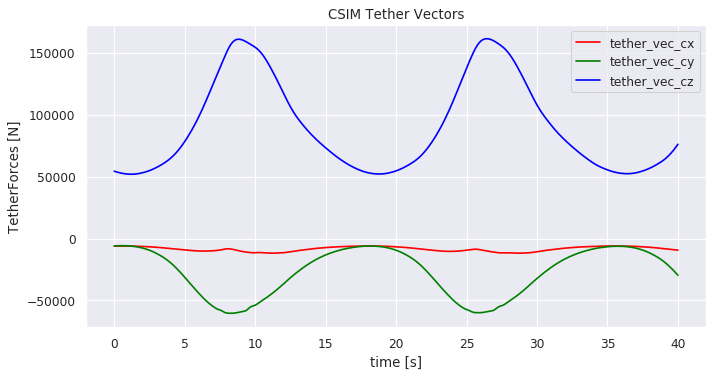

In [212]:
#Calculate vector components of that force to compare to KFAST
tether_vec_c=np.zeros([tether_force_b_c.size,3])
ph=csim_dset['tether_force_b']['roll'][tel_idx0:]
th=csim_dset['tether_force_b']['pitch'][tel_idx0:]
tether_vec_c[:,2]=tether_force_b_c*np.cos(ph)*np.cos(th)
tether_vec_c[:,1]=-tether_force_b_c*np.sin(ph)
tether_vec_c[:,0]=-tether_force_b_c*np.cos(ph)*np.sin(th)
tether_vec_c.shape
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k');
ax = fig.add_subplot(111)

for ii in range(0,3):
    ax.plot(time_c2k,tether_vec_c[:,ii], label='tether_vec_c'+coords[ii],color=colors[ii])
    #ax.plot(time_c[::5],Ag_c2[:,ii], label='estimator Ag_c2_',color=colors[ii],linestyle='--')
    
#ax.set_aspect('equal')
plt.xlabel('time [s]')
plt.ylabel('TetherForces [N]')
plt.title('CSIM Tether Vectors')
plt.legend(loc='best')
plt.show()

In [213]:
#now get the resultant Aero Forces and moments
F_aero_c=tel['wing']['fm_aero']['force']
M_aero_c=tel['wing']['fm_aero']['moment']
F_aero_c.dtype, F_aero_c['x'].shape
F_aero_c=np.array(F_aero_c.tolist(),dtype='float')[tel_idx0:,:]
M_aero_c=np.array(M_aero_c.tolist(),dtype='float')[tel_idx0:,:]
FM_aero_c=np.hstack([F_aero_c, M_aero_c])
FM_aero_c.shape,F_aero_c.shape

((2001, 6), (2001, 3))

## CSIM AnchorPt, Xg, Vg, DCM and ROTATIONAL VELOCITIES TO START THE KFAST SIMULATION

In [214]:
# Anchor point in CSIM is (from the slewring):
AnchPt_c=tel['tether']['Xg_start'][tel_idx0:]
print(AnchPt_c.shape)
AnchPt0_c=np.array(AnchPt_c[0].tolist(),dtype='float')
init_AnchPt_k=np.matmul(dcm_cg2fg,AnchPt0_c.reshape([3,1]))
init_AnchPt_k

(2001,)


array([[ 1.66036267],
       [-0.27511689],
       [ 1.70200167]])

In [215]:
# CSIM Xg is from the slew bearing (NOT anchor point); so this should be ok in KFAST
Xg_c=csim_dset['Xg'][tel_idx0:]
#Xg_c2k are c data massaged for KiteFAST to ingest it in its global coordinate system
# so Rotate the data
Xg_c2k=np.array(Xg_c.tolist(),dtype='float')
Xg_c2k=np.matmul(dcm_cg2fg, Xg_c2k.transpose()  ).transpose()
Xg_c2k 

#start point to initialize KFAST
init_Xg_k=Xg_c2k[0,:]
print(('Xg[0] for KFAST .mbd and .set = '+ 3*' {:17.10f}').format(*init_Xg_k))
print(423.44-421.644)

Xg[0] for KFAST .mbd and .set =     299.6791918037     17.5337634440    313.7610198871
1.7959999999999923


In [216]:
Xg_c2k.shape

(2001, 3)

In [217]:
# CSIM Xg_end is the bridle knot that goes into Moordyn Input
knot_c=tel['tether']['Xg_end'][tel_idx0:]
#start point to initialize KFAST
#dcm_fg2cg*np.array([Xg_c[0]])
knot0_c=np.array(knot_c[0].tolist(),dtype='float')
init_knot0_k=np.matmul(dcm_cg2fg, knot0_c.reshape([3,1]))
init_knot0_k=init_knot0_k
print( ('Bridle Knot for KFAST moordyn = '+ 3*' {:17.10f}').format(*init_knot0_k.flatten()) )

Bridle Knot for KFAST moordyn =     296.4437816960     17.6693975305    310.0464825868


In [218]:
#Note you can have a sense for the length of the stretching
np.linalg.norm(init_knot0_k-init_AnchPt_k)

426.960874836629

In [219]:
# CSIM Vg  (similarly to Xg); 
Vg_c=csim_dset['Vg'][tel_idx0:]
Vg_c2k=np.array(Vg_c.tolist(),dtype='float')
Vg_c2k=np.matmul(dcm_cg2fg, Vg_c2k.transpose()  ).transpose()
Vg_c2k 

#start point to initialize KFAST
init_Vg_k=Vg_c2k[0,:]
init_Vg_k
print( ('MIP RF initial vel = '+ 3*' {:17.10f}').format(*init_Vg_k) )
print( ('reference, global,  '+ 3*' {:17.10f},').format(*init_Vg_k) )

MIP RF initial vel =     -10.5183018943    -33.0589012385     11.8170092933
reference, global,      -10.5183018943,    -33.0589012385,     11.8170092933,


In [220]:
# CSIM Vb in body coordinates
Vb_c=csim_dset['Vb'][tel_idx0:]
Vb_c2k=np.array(Vb_c.tolist(),dtype='float')
Vb_c2k 

array([[35.25357658, -7.60818173, -6.51676637],
       [35.25746963, -7.63040963, -6.52218185],
       [35.26176147, -7.65257728, -6.52763386],
       ...,
       [51.75488924, -4.32748262, -9.89947824],
       [51.88863482, -4.25448711, -9.89044074],
       [52.02235184, -4.18132289, -9.88072189]])

In [221]:
# CSIM wind_g in ground coordinates
wind_g_c=csim_dset['wind_g'][tel_idx0:]
# Now rotate in KFAST ref frame
wind_g_c2k=np.array(wind_g_c.tolist(),dtype='float')
wind_g_c2k= np.matmul(dcm_cg2fg, wind_g_c2k.transpose()  ).transpose()
wind_g_c2k

array([[1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       ...,
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00],
       [1.20000000e+01, 1.46957616e-15, 0.00000000e+00]])

In [222]:
# CSIM apparent_wind_b in body coordinates as magnutide, alpha, and beta
apparent_wind_b_c=csim_dset['apparent_wind_b'][tel_idx0:]
# 
apparent_wind_b_c=np.array(apparent_wind_b_c.tolist(),dtype='float')
apparent_wind_b_c

array([[ 4.17085912e+01,  3.75078865e-02, -3.50978911e-02],
       [ 4.16939573e+01,  3.73389128e-02, -3.51199250e-02],
       [ 4.16795923e+01,  3.71714696e-02, -3.51436957e-02],
       ...,
       [ 4.89622502e+01,  2.82498310e-02, -2.81441252e-02],
       [ 4.90520196e+01,  2.84898747e-02, -2.78981458e-02],
       [ 4.91420391e+01,  2.87346831e-02, -2.76548503e-02]])

## Next is very important : it is the DCM_G2B from CSIM!

In [223]:
# CSIM DCMG2B -  Seq XYZ capital letters for intrinsic!!! 
#
dcm_g2b_c=csim_dset['dcm_g2b']['d'][tel_idx0:,:,:]  #the 'd' gets the double stuff out as (n,3,3)
# The rows of dcmg2b are the local unit vectors in CSIM ref frame

# Tranform to euler angles : !!!! WATCH: ROTATION wants L2G and not G2L to describe rotation from G 2 L (beats me...)
r_c=myRotation.from_dcm(dcm_g2b_c.transpose([0,2,1]))
euler_c=r_c.as_euler('XYZ', degrees=False) #These are w.r.t. CSIM ground ref. frame

# Then we get the DCM_G2B in KFAST ref frame as g2b_c *C2F.T
dcm_g2b_c2k=np.matmul( dcm_g2b_c, dcm_cg2fg.transpose()  )
init_DCMg2b_k=dcm_g2b_c2k[0,:,:]
# The ROWS of the following are the 1, ,, 2,,   3,, data to use in the MBDYN vectors initial mip_rf in KiteMain.set
print(('reference, global, 1, '+3*'{:.13f}, ').format(*init_DCMg2b_k[0,:]))
print(('\t, 2, '+3*'{:.13f}, ').format(*init_DCMg2b_k[1,:]))
print(('\t, 3, '+3*'{:.13f}, ').format(*init_DCMg2b_k[2,:]))


reference, global, 1, -0.5333342054324, -0.7779822245043, 0.3321118541564, 
	, 2, -0.5120498890263, 0.6094287256721, 0.6053111096567, 
	, 3, -0.6733197876670, 0.1527752816431, -0.7233948968959, 


## Now continue on to accelerations Ag and Ab

In [224]:
# CSIM Ab in body coordinates
Ab_c=csim_dset['Ab'][tel_idx0:]
Ab_c2k=np.array(Ab_c.tolist(),dtype='float')
Ab_c2k.shape 

(2001, 3)

In [225]:
# CSIM Ag is stored in the estimator and not in the simulator. Let us check this:
Ag_c2=csim_dset2['Ag'][tel2_idx0:]
Ag_c2=np.array(Ag_c2.tolist(),dtype='float')
Ag_c2.shape

(401, 3)

In [226]:
# Another way of getting it is through manipulation of Ab_c via dcm_g2b_c
Ag_c=np.einsum('kij,kj->ki', dcm_g2b_c.transpose([0,2,1]), Ab_c2k)  #this is the way i managed to get matmul to work with 3d x 2d arrays
#since j disappears, it is summed upon
Ag_c.shape, Ab_c.shape, Ag_c.shape

((2001, 3), (2001,), (2001, 3))

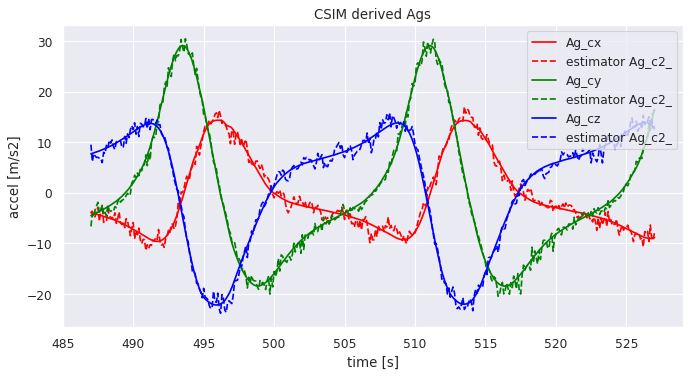

In [227]:
#Compare these 2 Ag_c's
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k');
ax = fig.add_subplot(111)

for ii in range(0,3):
    ax.plot(time_c,Ag_c[:,ii], label='Ag_c'+coords[ii],color=colors[ii])
    ax.plot(time_c[::5],Ag_c2[:,ii], label='estimator Ag_c2_',color=colors[ii],linestyle='--')
    
#ax.set_aspect('equal')
plt.xlabel('time [s]')
plt.ylabel('accel [m/s2]')
plt.title('CSIM derived Ags')
plt.legend(loc='best')
plt.show()

### From the above plot, we can conclude that Ag_c (manipulation of Ab) is fine, and the estimator has noise in it, which is more realistic.  In the next cell create Ag_c2k, i.e. Ag_c in KiteFAST reference frame

In [228]:
Ag_c2k=np.matmul(dcm_cg2fg, Ag_c.transpose()  ).transpose()
Ag_norm_c=np.linalg.norm(Ag_c2k,axis=1)
Ag_norm_c 

array([ 9.7625356 ,  9.7699048 ,  9.77751754, ..., 22.36925186,
       22.47907915, 22.58829744])

In [229]:
#Then create euler angles from the dcms based on kfast reference
r_k=myRotation.from_dcm(dcm_g2b_c2k.transpose([0,2,1]))
euler_c2k=r_k.as_euler('XYZ', degrees=False) 
#Also create rotvecs used by MBDYN in the file driver input file
rotvec_c2k=r_k.as_rotvec() 

In [230]:
# You may also use one of the two following commands to define mip_rf in KiteMain.set, as printed out below
print(('reference, global, euler, degrees, '+3*'{:.13f}, ').format(*np.rad2deg(euler_c2k[0,:])))
print(('reference, global, vector, '+3*'{:.13f}, ').format(*rotvec_c2k[0,:]))

reference, global, euler, degrees, -168.0748196337274, -42.3238076007010, 136.1663971520833, 
reference, global, vector, 1.0128879580870, -2.2504065747737, -0.5952228389383, 


In [231]:
# to compare to CSIM version of euler 
print(('CSIM-frame euler angles, degrees, '+3*'{:.13f}, ').format(*np.rad2deg(euler_c2k[0,:])))

CSIM-frame euler angles, degrees, -168.0748196337274, -42.3238076007010, 136.1663971520833, 


In [232]:
rotvec_c2k[0,:]

array([ 1.01288796, -2.25040657, -0.59522284])

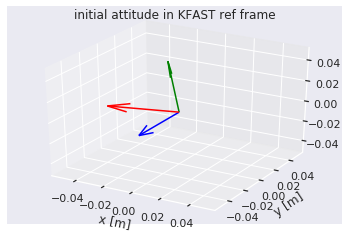

In [233]:
if injupyter:
    %matplotlib inline
# For sanity check let us plot this frame which shoudl be oriented like the aircraft at initial conditions
fig=plt.figure();
ax = fig.add_subplot(111, projection='3d')

for ii in range(0,3):
    ax.quiver(0,0,0, init_DCMg2b_k[ii,0], init_DCMg2b_k[ii,1],init_DCMg2b_k[ii,2],length=0.05,color=colors[ii])
#ax.set_aspect('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('initial attitude in KFAST ref frame')
#scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz']); 
#ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)

#set_axes_equal(ax)  
plt.show()

In [234]:
 # CSIM omega -  THESE ARE IN  BODY REFERENCE
omega_c=csim_dset['omega'][tel_idx0:]  #the 'd' gets the double stuff out as (n,3,3)
omega_c=np.array(omega_c.tolist(),dtype='float')

#For MBDYN initialization we need to transform them to global

init_omegag_k=np.matmul(dcm_g2b_c2k[0,:,:],omega_c[0,:])
print(('reference, global, ' + 3*'{:.10f}, ').format(*init_omegag_k))

reference, global, -0.0045340414, -0.1518348500, 0.1858510640, 


#### the above initial conditions to set into KiteMain.set, and Xg goes into KiteMain.mbd ofr the first keypoint in the usr-module section; Then You should get the position.txt that contains the Xg locations and orientations for all time steps

In [235]:
####To create a position.txt file, let us create a file from here

In [236]:
#Let us start with Xg
#np.array(Xg_c.tolist(),dtype='float')


In [237]:
rotvec_c2k.shape, np.linalg.norm(rotvec_c2k[0,:])
#rotvec_k

((2001, 3), 2.538614187980576)

In [238]:
testrot=myRotation.from_euler('XYZ',euler_c2k[0,:])
testrot.as_dcm()

array([[-0.53333421, -0.51204989, -0.67331979],
       [-0.77798222,  0.60942873,  0.15277528],
       [ 0.33211185,  0.60531111, -0.7233949 ]])

In [239]:
# %%javascript
# var kernel = IPython.notebook.kernel;
# var thename = window.document.getElementById("notebook_name").innerHTML;
# var command = "theNotebook = " + "'"+thename+"'";
# kernel.execute(command);

In [240]:
#This cell has problems when run automatically, but it works fine if manually run, I comment it out and assign the name

##The cell above would not work in a regular script, and %%javascript must sit at the top of the cell, so this is another way:
#if injupyter:
#    get_ipython().run_cell_magic('javascript', '', 'var kernel = IPython.notebook.kernel;\nvar thename = window.document.getElementById("notebook_name").innerHTML;\nvar command = "theNotebook = " + "\'"+thename+"\'";\nkernel.execute(command);')
#else:
#    theNotebook=__file__
theNotebook='KFASTvsCSIM'

In [241]:
theNotebook

'KFASTvsCSIM'

In [242]:
time_c.shape, dcm_g2b_c2k.shape

((2001,), (2001, 3, 3))

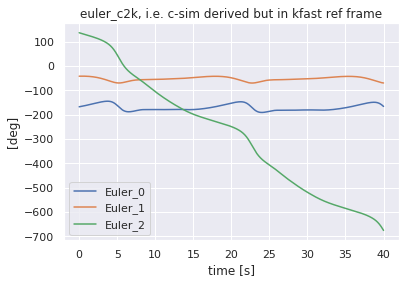

In [243]:
#Let us plot euler angles for Sanity check -- The x roll angle seems weird because it is about -180. I do not get it, but it seems to work
if injupyter:
    %matplotlib inline
plt.figure();
for ii in range(0,3):
    #plt.plot(time_c2k,np.rad2deg(np.unwrap(euler_k[:,ii],discont=np.pi,axis=0)),label='Euler_'+str(ii))
    plt.plot(time_c2k,np.rad2deg(np.unwrap(euler_c2k[:,ii])),label='Euler_'+str(ii))
plt.xlabel('time [s]')
plt.ylabel('[deg]')
plt.title('euler_c2k, i.e. c-sim derived but in kfast ref frame')
plt.legend(loc='best')
plt.show()

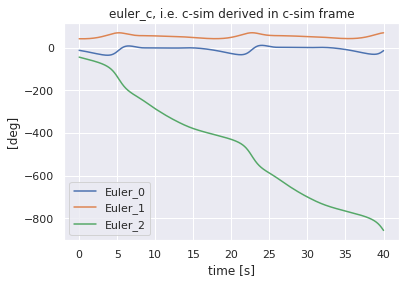

In [244]:
if injupyter:
    %matplotlib inline
plt.figure();
for ii in range(0,3):
    plt.plot(time_c2k,np.rad2deg(np.unwrap(euler_c[:,ii],discont=np.pi,axis=0)),label='Euler_'+str(ii))

plt.xlabel('time [s]')
plt.ylabel('[deg]')
plt.title('euler_c, i.e. c-sim derived in c-sim frame')
plt.legend(loc='best')
plt.show()

In [245]:
%matplotlib notebook

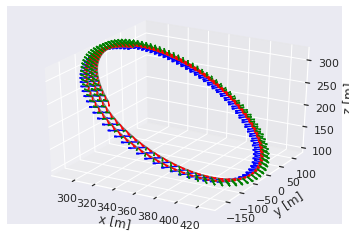

In [246]:
# Let us plot as vectors as I do not know whether it will work ok due to jumps in the angles above
if injupyter:
    %matplotlib inline
## %matplotlib notebook 
## %matplotlib notebook
fig=plt.figure();
ax=plt.axes(projection='3d')
ax.plot3D(Xg_c2k[:,0],Xg_c2k[:,1],Xg_c2k[:,2], 'gray')
for ii in range(0,3):
    ax.quiver(Xg_c2k[::10,0],Xg_c2k[::10,1],Xg_c2k[::10,2], dcm_g2b_c2k[::10,ii,0], dcm_g2b_c2k[::10,ii,1], dcm_g2b_c2k[::10,ii,2], length=10,color=colors[ii])

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

plt.show()

## Results from this seems ok, let us test in FAST. There was an issue with the rotational vectors changing sign at one point, so flipping, and it is not clear why. 
## However, this happens when the magnitude of the rotation exceeds pi. So here is an algorithm to unwrap the rotvecs, and then the position file is rewritten. Moved it down here from brevity sake and remove duplication.

In [247]:
#First find indices of where it happens
chsign=np.sign(rotvec_c2k[1:,:])*np.sign(rotvec_c2k[:-1,:])
junk=chsign.sum(axis=1)==-3.
idx_jumps=np.where(junk)[0]+1
nidx=len(idx_jumps)
print(idx_jumps, nidx)
print(rotvec_c2k[idx_jumps[0]-1:idx_jumps[0]+2,:])

[ 310 1191] 2
[[ 2.63361821  0.15659934 -1.7045058 ]
 [-2.63220748 -0.1710336   1.6994512 ]
 [-2.62969858 -0.18533431  1.69369784]]


In [248]:
np.rad2deg(np.linalg.norm(rotvec_c2k[idx_jumps[0]-1:idx_jumps[0]+2,:],axis=1))

array([179.9653798 , 179.7837398 , 179.53132928])

In [249]:
# Then create an unwrapped vector which  has (pi+(pi-norm)) for the new norm and opposite signs when flip happens and till next flip
rotvec_c2ku=rotvec_c2k.copy() 
for ii in range(0,nidx,2):
    if ii < nidx-1:
        print(ii,idx_jumps[ii])
        endidx=idx_jumps[ii+1]
        print(endidx)
    else:
        endidx=rotvec_c2k.size[0]
    norm_factor=(2*np.pi-np.linalg.norm(rotvec_c2k[idx_jumps[ii]:endidx],axis=1))/np.linalg.norm(rotvec_c2k[idx_jumps[ii]:endidx,:],axis=1)    
    rotvec_c2ku[idx_jumps[ii]:endidx,:]=-rotvec_c2k[idx_jumps[ii]:endidx,:]*np.tile(norm_factor.reshape(-1,1),[1,3])

0 310
1191


In [250]:
# confirm we have no jumps in the new unwrapped rotvec
chsign=np.sign(rotvec_c2ku[1:,:])*np.sign(rotvec_c2ku[:-1,:])
junk=chsign.sum(axis=1)==-3.
idx_jumps=np.where(junk)[0]+1
nidx=len(idx_jumps)
print(idx_jumps, nidx)
time_c2k[659:670].T,rotvec_c2ku[659:670,:]

[] 0


(array([[13.18, 13.2 , 13.22, 13.24, 13.26, 13.28, 13.3 , 13.32, 13.34,
         13.36, 13.38]]), array([[ 0.30302437,  4.03237018, -0.11873307],
        [ 0.29083623,  4.03316253, -0.11327743],
        [ 0.27867792,  4.0338921 , -0.10784607],
        [ 0.26655096,  4.03455943, -0.10243699],
        [ 0.25445736,  4.03516504, -0.09704807],
        [ 0.24239851,  4.03570973, -0.09167819],
        [ 0.23037588,  4.03619434, -0.0863255 ],
        [ 0.21839074,  4.03661903, -0.0809885 ],
        [ 0.2064439 ,  4.03698393, -0.07566702],
        [ 0.19453645,  4.03728924, -0.07036057],
        [ 0.18266885,  4.03753496, -0.06507054]]))

In [251]:
### Now write to position file : This file must be read in by MBDyn, so put its name in the first joint defined in KiteMain.mbd

with open(path2posfile,"w") as f:
    f.write('#This file contains position data from CSIM output file {:s}\n'.format(str(path2cfile)))
    f.write('#This file was generated by {:s} on {:s}\n'.format(theNotebook,str(datetime.datetime.now())))
    f.write(str('# '+7*'{:12s} '+'\n').format('t[s]','x[m]','y[m]','z[m]','rotvec_X[rad]', 'rotvec_Y[rad]','rotvec_Z[rad]\n'))
    np.savetxt(f, np.hstack([time_c2k,Xg_c2k, rotvec_c2ku]), fmt='%.10f', delimiter=' ', newline='\n')    
    

### Also Write   A File of "Controller Outputs" that could be read in by KFAST in a special mode
### and use its first row to set the initial conditions in the controller input file.

In [252]:
#first set up labels
nmotstr=np.linspace(1,nmotors,nmotors)
nmotstr=[str(int(i)) for i in nmotstr]
nflapstr=np.linspace(1,nflaps,nflaps)
nflapstr=[str(int(i)) for i in nflapstr]

Gentorquestr= np.core.defchararray.add(np.tile('GenTorq',nmotors),np.core.defchararray.add(nmotstr, ' [Nm]'))
RtrSpdstr= np.core.defchararray.add(np.tile('RtrSpd',nmotors),np.core.defchararray.add(nmotstr, ' [rad/s]'))
RtrAccstr= np.core.defchararray.add(np.tile('RtrAcc',nmotors),np.core.defchararray.add(nmotstr, ' [rad/s^2]'))
RtrPitchstr= np.core.defchararray.add(np.tile('BlPitch',nmotors),np.core.defchararray.add(nmotstr, ' [rad]'))
Flapstr= np.core.defchararray.add(np.tile('Flap',nflaps),np.core.defchararray.add(nflapstr, ' [rad]'))

nmotstr,Gentorquestr,Flapstr

(['1', '2', '3', '4', '5', '6', '7', '8'],
 array(['GenTorq1 [Nm]', 'GenTorq2 [Nm]', 'GenTorq3 [Nm]', 'GenTorq4 [Nm]',
        'GenTorq5 [Nm]', 'GenTorq6 [Nm]', 'GenTorq7 [Nm]', 'GenTorq8 [Nm]'],
       dtype='<U13'),
 array(['Flap1 [rad]', 'Flap2 [rad]', 'Flap3 [rad]', 'Flap4 [rad]',
        'Flap5 [rad]', 'Flap6 [rad]', 'Flap7 [rad]', 'Flap8 [rad]'],
       dtype='<U11'))

In [253]:
## testing string formatting
##aa=np.hstack([time_c2k, gen_torque_c, rot_speed_c, rot_accel_c,blpitch_c,  flaps_c])
##aa.dtype
##np.hstack(['t[s]',Gentorquestr,RtrSpdstr,RtrAccstr,RtrPitchstr, Flapstr,'\n']).tolist()

In [254]:
str('# '+(nmotors)*'{:12s} '+'\n').format(*Gentorquestr.tolist())

'# GenTorq1 [Nm] GenTorq2 [Nm] GenTorq3 [Nm] GenTorq4 [Nm] GenTorq5 [Nm] GenTorq6 [Nm] GenTorq7 [Nm] GenTorq8 [Nm] \n'

In [255]:
#blade pitch is 0 by default
blpitch_c=np.zeros_like(gen_torque_c)

with open(path2CtrlOuts,"w") as f:
    f.write('#This file contains CTRL output data to be read in by KiteFastController.f90 from data in {:s}\n'.format(str(path2cfile)))
    f.write('#This file was generated by {:s} on {:s}\n'.format(theNotebook,str(datetime.datetime.now())))
    
    f.write(str('#  {:>15s}'+(4*nmotors+nflaps)*'{:>18s}'+'\n').format(*np.hstack(['t[s]',Gentorquestr,RtrSpdstr,RtrAccstr,RtrPitchstr, Flapstr,'\n']).tolist()))
    np.savetxt(f, np.hstack([time_c2k, gen_torque_c, rot_speed_c, rot_accel_c,blpitch_c,  flaps_c]), fmt='% 18.10f', delimiter='', newline='\n')    


### Also Write   A File of "Controller Inputs" that could be read in by KFCdriver to test STI ctrl 

In [256]:
time_c2k.shape,Xg_c['x'].shape,Vg_c.shape,Ag_c.shape, Vb_c.shape, Ab_c.shape,omega_c.shape,wind_g_c.shape,tether_force_b_c.shape

((2001, 1),
 (2001,),
 (2001,),
 (2001, 3),
 (2001,),
 (2001,),
 (2001, 3),
 (2001,),
 (2001,))

In [257]:
np.hstack([time_c2k,Ag_c]).shape,rho_c.shape

((2001, 4), (1,))

In [258]:
tether_force_b_c.shape,np.tile(rho_c,len(time_c2k)).shape

((2001,), (2001,))

In [259]:
dcm_g2b_c.reshape([-1,9],order='F').shape,aero_torque_c.shape,apparent_wind_b_c.shape

((2001, 9), (2001, 8), (2001, 3))

In [260]:
#we need to get apparent_wind back to KFAST definition, i.e. vector components
app_wind_c=apparent_wind_b_c*0. #initialize
alph=apparent_wind_b_c[:,1]
bet=apparent_wind_b_c[:,2]
app_wind_c[:,0]=np.cos(alph)*np.cos(bet)*apparent_wind_b_c[:,0]*np.sign(alph) # z component
app_wind_c[:,1]=-np.sin(bet)*apparent_wind_b_c[:,0] # y component
app_wind_c[:,2]=app_wind_c[:,0]*np.sin(alph)/np.cos(alph) # x component

In [261]:
#Let us also get acc_norm; the only one available is acc_norm_f and from tel3 it is at twice the frequency
acc_norm_f=tel3['state_est']['acc_norm_f'][tel3_idx0:]
#Ab_c2k=np.array(Ab_c.tolist(),dtype='float')
acc_norm_f.shape 
#So decimate it by simple interpolation for now:
acc_norm_c=np.interp(time_c2k, tel3['time'][tel3_idx0:], acc_norm_f)
acc_norm_c.shape

(2001, 1)

In [262]:
dcm_g2b_c[0,:,:],dcm_g2b_c[0,:,:].reshape(9,order='F')

(array([[ 0.53333421, -0.77798222, -0.33211185],
        [ 0.51204989,  0.60942873, -0.60531111],
        [ 0.67331979,  0.15277528,  0.7233949 ]]),
 array([ 0.53333421,  0.51204989,  0.67331979, -0.77798222,  0.60942873,
         0.15277528, -0.33211185, -0.60531111,  0.7233949 ]))

In [263]:
#manipulate arrays a bit so that we have everything in one big array, also take care of quantities like apparent_wind that is manipulated by STI instead

Xg1=np.vstack([Xg_c['x'],Xg_c['y'],Xg_c['z']]).T
Vg1=np.vstack([Vg_c['x'],Vg_c['y'],Vg_c['z']]).T
Vb1=np.vstack([Vb_c['x'],Vb_c['y'],Vb_c['z']]).T
Ab1=np.vstack([Ab_c['x'],Ab_c['y'],Ab_c['z']]).T
wind_g1=np.vstack([wind_g_c['x'],wind_g_c['y'],wind_g_c['z']]).T
outarray=np.hstack([time_c2k, np.tile(rho_c,[len(time_c2k),1]), Xg1,Vg1, Ag_c, acc_norm_c, Vb1, Ab1, omega_c, wind_g1, app_wind_c, tether_vec_c, dcm_g2b_c.reshape([-1,9],order='F'), aero_torque_c])
outarray.shape

(2001, 47)

In [264]:
#write the file now
with open(path2STIInps,"w") as f:
    f.write('#This file (ignored if  KFCdrivermode=2) contains CTRL input data to be read in by KFCdriver from data in {:s}\n'.format(str(path2cfile)))
    f.write('#This file was generated by {:s} on {:s}\n'.format(theNotebook,str(datetime.datetime.now())))
    f.write(str('#  {:>15s}'+46*'{:>18s}'+'\n').format(*['t_c', 'rho_c', 'Xg_c_x', 'Xg_c_y', 'Xg_c_z', 'Vg_c_x', 'Vg_c_y', 'Vg_c_z', 'Ag_c_x', 'Ag_c_y', 'Ag_c_z', 'acc_norm_c', 'Vb_c_x', 'Vb_c_y','Vb_c_z', 'Ab_c_x', 'Ab_c_y', 'Ab_c_z', 'pqr_c(1)', 'pqr_c(2)', 'pqr_c(3)', 'wind_g_c(1)', 'wind_g_c(2)', 'wind_g_c(3)', 'app_wind_c(1)',  'app_wind_c(2)',   'app_wind_c(3)',  'tether_vec_c(1)',  'tether_vec_c(2)',   'tether_vec_c(3)',   'dcm_g2b_c(1)',  'dcm_g2b_c(2)',  'dcm_g2b_c(3)',  'dcm_g2b_c(4)',   'dcm_g2b_c(5)',  ' dcm_g2b_c(6)',  'dcm_g2b_c(7)',   'dcm_g2b_c(8)',    'dcm_g2b_c(9)',    'aeroTorq(1)',     'aeroTorq(2)',      'aeroTorq(3)',      'aeroTorq(4)',      'aeroTorq(5)',      'aeroTorq(6)',      'aeroTorq(7)',      'aeroTorq(8)']))  
    f.write(str('#  {:>15s}'+46*'{:>18s}'+'\n').format(*['[s]','[kg/m3]','[m]',     '[m]',     '[m]',  '[m/s]',  '[m/s]',  '[m/s]',  '[m/s2]',  '[m/s2]','[m/s2]', '[m/s2]',      '[m/s]',  '[m/s]','[m/s]',   '[m/s2]',  '[m/s2]','[m/s2]',   '[rad/s]','[rad/s]','[rad/s]',     '[m/s]',      '[m/s]',        '[m/s]',       '[m/s]',         '[m/s]',             '[m/s]',              '[N]',                   '[N]',             '[N]',              '[-]',           '[-]',          '[-]',         '[-]',            '[-]',             '[-]',            '[-]',           '[-]',             '[-]',             '[Nm]',            '[Nm]',              '[Nm]',           '[Nm]',            '[Nm]',              '[Nm]',            '[Nm]',             '[Nm]']))     
    np.savetxt(f, outarray, fmt='% 18.10f', delimiter='', newline='\n')    


# Finally Load KFAST output

In [265]:
# Read KFAST Output os.path.join(dir_name, base_filename + "." + format)
df=pd.read_csv(path2kfile,header=1,squeeze=True,delim_whitespace=True,skiprows=1,low_memory=False); #nrows=10,b

In [266]:
# Read KFC Output 
df_kfc=pd.read_csv(path2kfcfile,header=1,squeeze=True,delim_whitespace=True,skiprows=1,low_memory=False); #nrows=10,b

In [267]:
# Read STI Output 
df_STI=pd.read_csv(path2STIOuts,header=3,index_col=False,skipinitialspace=True,low_memory=False); #nrows=10,b
df_STI.tail(10)

time    dcm0_0    dcm0_1    dcm0_2    dcm1_0    dcm1_1    dcm1_2  \
756  7.56 -0.360078  0.702241  0.614168 -0.393468 -0.711225  0.582531   
757  7.57 -0.358837  0.705669  0.610956 -0.395153 -0.707849  0.585495   
758  7.58 -0.357592  0.709081  0.607727 -0.396817 -0.704457  0.588453   
759  7.59 -0.356333  0.712468  0.604497 -0.398504 -0.701056  0.591367   
760  7.60 -0.355070  0.715838  0.601250 -0.400170 -0.697639  0.594276   
761  7.61 -0.353793  0.719182  0.598003 -0.401857 -0.694214  0.597141   
762  7.62 -0.352512  0.722510  0.594739 -0.403523 -0.690774  0.600001   
763  7.63 -0.351218  0.725811  0.591477 -0.405206 -0.687327  0.602818   
764  7.64 -0.349921  0.729095  0.588197 -0.406869 -0.683864  0.605630   
765  7.65 -0.348611  0.732352  0.584920 -0.408545 -0.680396  0.608401   

       dcm2_0    dcm2_1    dcm2_2  ...   aileron  inboard_flap  midboard_flap  \
756  0.845888 -0.031899  0.532405  ...  0.802988           0.0            0.0   
757  0.845630 -0.031324  0.532849  ...  0.809789           0.0            0.0   
758  0.845378 -0.030730  0.533284  ...  0.814639           0.0            0.0   
759  0.845116 -0.030171  0.533730  ...  0.821287           0.0            0.0   
760  0.844860 -0.029593  0.534168  ...  0.826091           0.0            0.0   
761  0.844596 -0.029047  0.534616  ...  0.832958           0.0            0.0   
762  0.844337 -0.028483  0.535056  ...  0.837623           0.0            0.0   
763  0.844070 -0.027949  0.535505  ...  0.844359           0.0            0.0   
764  0.843809 -0.027396  0.535945  ...  0.849019           0.0            0.0   
765  0.843541 -0.026871  0.536392  ...  0.855698           0.0            0.0   

     outboard_flap  elevator    rudder        thrust  moment_x    moment_y  \
756            0.0 -0.896643 -0.814348 -14281.923050       0.0  431.370672   
757            0.0 -0.896573 -0.820825 -14269.847582       0.0  428.804137   
758            0.0 -0.896690 -0.827034 -14269.847582       0.0  428.869806   
759            0.0 -0.896629 -0.833511 -14257.895205       0.0  426.326581   
760            0.0 -0.896754 -0.839644 -14257.895205       0.0  426.395617   
761            0.0 -0.896703 -0.845952 -14246.060483       0.0  423.874826   
762            0.0 -0.896836 -0.852149 -14246.060483       0.0  423.947371   
763            0.0 -0.896795 -0.858478 -14234.341941       0.0  421.449218   
764            0.0 -0.896937 -0.864613 -14234.341941       0.0  421.525603   
765            0.0 -0.896908 -0.870923 -14222.742103       0.0  419.051432   

        moment_z  
756  8990.072773  
757  9023.622442  
758  9095.188418  
759  9128.460746  
760  9198.772355  
761  9228.875583  
762  9299.937491  
763  9330.070318  
764  9400.020071  
765  9429.552272  

[10 rows x 111 columns]

# Extract time into 1 var

In [268]:
time_k=df.loc[1:,'Time'].values.astype('float')
time_k
dt_k=time_k[1]-time_k[0]
dt_k, dt_c

(0.002, 0.01999999999998181)

In [269]:
#decimate to the frequency of csim
decimation=int(round(dt_c/dt_k))
print('decimation ={:5.3f}'.format(decimation))
idx_k=df.index[1::decimation]

decimation =10.000


## Get KFAST trajectory & PLOT against CSIM-derived one

In [270]:
df.head()

Time    KitePxi    KitePyi    KitePzi    KiteRoll   KitePitch  \
0         s        (m)        (m)        (m)       (deg)       (deg)   
1  0.000000  2.997E+02  1.753E+01  3.138E+02  -1.681E+02  -4.232E+01   
2  0.002000  2.997E+02  1.747E+01  3.138E+02  -1.681E+02  -4.232E+01   
3  0.004000  2.996E+02  1.740E+01  3.138E+02  -1.681E+02  -4.232E+01   
4  0.006000  2.996E+02  1.734E+01  3.138E+02  -1.680E+02  -4.232E+01   

     KiteYaw    KiteTVx     KiteTVy     KiteTVz  ...   PWn9Vrel  Wind1VelX  \
0      (deg)      (m/s)       (m/s)       (m/s)  ...    INVALID      (m/s)   
1  1.362E+02  0.000E+00   0.000E+00   0.000E+00  ...  0.000E+00  1.200E+01   
2  1.361E+02  7.049E+01  -1.537E+01  -1.300E+01  ...  0.000E+00  1.200E+01   
3  1.361E+02  3.525E+01  -7.669E+00  -6.505E+00  ...  0.000E+00  1.200E+01   
4  1.361E+02  3.525E+01  -7.653E+00  -6.510E+00  ...  0.000E+00  1.200E+01   

    Wind1VelY  Wind1VelZ   FAIRTEN1   FAIRTEN2   FAIRTEN3   ANCHTEN1  \
0       (m/s)      (m/s)        (N)        (N)        (N)        (N)   
1  -0.000E+00  0.000E+00  7.466E+01  3.822E+05  4.864E+05  5.257E+04   
2  -0.000E+00  0.000E+00  2.025E+04  1.811E+05  1.182E+05  5.256E+04   
3  -0.000E+00  0.000E+00  4.093E+03  2.880E+04  7.504E+04  5.256E+04   
4  -0.000E+00  0.000E+00  2.639E+03  7.383E+04  5.843E+04  5.255E+04   

    ANCHTEN2   ANCHTEN3  
0        (N)        (N)  
1  7.466E+01  7.466E+01  
2  2.025E+04  2.025E+04  
3  4.093E+03  4.093E+03  
4  2.639E+03  2.639E+03  

[5 rows x 392 columns]

#### So we will need to remove first row with units for kfast

In [271]:
df.tail()

Time    KitePxi     KitePyi    KitePzi    KiteRoll   KitePitch  \
19996  39.990000  3.205E+02  -1.405E+02  2.579E+02  -1.663E+02  -7.019E+01   
19997  39.992000  3.206E+02  -1.406E+02  2.578E+02  -1.663E+02  -7.019E+01   
19998  39.994000  3.206E+02  -1.406E+02  2.577E+02  -1.664E+02  -7.020E+01   
19999  39.996000  3.207E+02  -1.407E+02  2.577E+02  -1.664E+02  -7.021E+01   
20000  39.998000  3.207E+02  -1.407E+02  2.576E+02  -1.665E+02  -7.021E+01   

         KiteYaw    KiteTVx     KiteTVy     KiteTVz  ...   PWn9Vrel  \
19996  4.457E+01  5.196E+01  -4.218E+00  -9.885E+00  ...  0.000E+00   
19997  4.446E+01  5.196E+01  -4.167E+00  -9.879E+00  ...  0.000E+00   
19998  4.435E+01  5.197E+01  -4.115E+00  -9.872E+00  ...  0.000E+00   
19999  4.425E+01  5.197E+01  -4.064E+00  -9.866E+00  ...  0.000E+00   
20000  4.414E+01  5.198E+01  -4.013E+00  -9.859E+00  ...  0.000E+00   

       Wind1VelX   Wind1VelY  Wind1VelZ   FAIRTEN1   FAIRTEN2   FAIRTEN3  \
19996  1.200E+01  -0.000E+00  0.000E+00  1.129E+03  4.693E+04  7.967E+04   
19997  1.200E+01  -0.000E+00  0.000E+00  8.290E+02  4.667E+04  7.843E+04   
19998  1.200E+01  -0.000E+00  0.000E+00  9.563E+02  4.800E+04  7.746E+04   
19999  1.200E+01  -0.000E+00  0.000E+00  1.062E+03  4.646E+04  7.560E+04   
20000  1.200E+01  -0.000E+00  0.000E+00  4.512E+02  4.703E+04  7.633E+04   

        ANCHTEN1   ANCHTEN2   ANCHTEN3  
19996  8.032E+04  1.129E+03  1.129E+03  
19997  8.036E+04  8.290E+02  8.290E+02  
19998  8.040E+04  9.563E+02  9.563E+02  
19999  8.042E+04  1.062E+03  1.062E+03  
20000  8.045E+04  4.512E+02  4.512E+02  

[5 rows x 392 columns]

In [272]:
KTrajstr=np.core.defchararray.add(np.tile('KiteP',ncoords),np.core.defchararray.add(coords,np.tile('i',ncoords)))
KTrajstr

array(['KitePxi', 'KitePyi', 'KitePzi'], dtype='<U7')

#### UPDATE 2/2020: Remember:I DO NOT need to remove the anchor point coordinates to match CSIM in KFAST KitePx,y,zi  !!

In [273]:
#Kfast
KTraj_df=df.loc[idx_k,KTrajstr.tolist()].astype('float')
junk=KTraj_df.to_numpy('float')
Xg_k=junk   #-init_AnchPt_k.transpose()  NO NEED FOR THIS, the slew ring is the origin for both KFAST and CSIM
KTraj_df.describe()

KitePxi      KitePyi      KitePzi
count  2000.000000  2000.000000  2000.000000
mean    343.027500   -22.034517   230.798775
std      48.602122    94.302519    81.003218
min     287.500000  -173.000000    94.060000
25%     296.700000  -110.125000   152.600000
50%     328.650000   -19.860000   254.900000
75%     389.625000    70.267500   308.600000
max     425.900000   116.300000   323.100000

In [274]:
Xg_k

array([[ 299.7 ,   17.53,  313.8 ],
       [ 299.5 ,   16.87,  314.  ],
       [ 299.3 ,   16.21,  314.2 ],
       ...,
       [ 319.4 , -139.3 ,  259.9 ],
       [ 319.8 , -139.8 ,  259.1 ],
       [ 320.3 , -140.3 ,  258.3 ]])

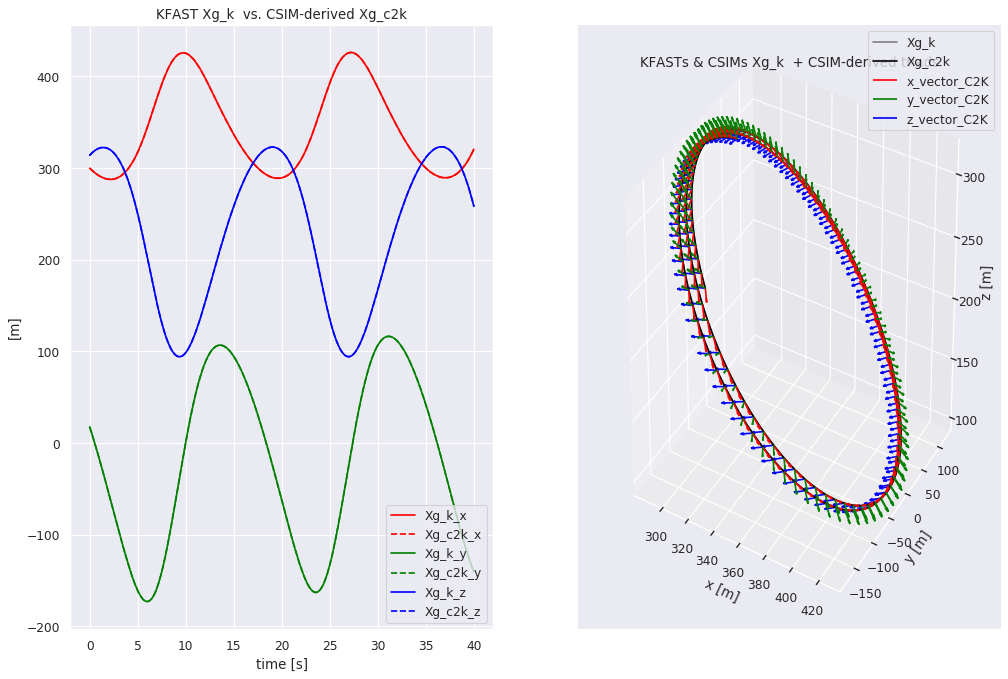

In [275]:
#Plot trajectories: 1st CSIM derived (in KFAST ref frame) vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook

fig= plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 2, 1)
#plt.subplot(1,2,1)
#Xg_k.plot(x=time_k[idx_k]) ; 
for ii in range(0,3):
    ax.plot(time_k[idx_k],Xg_k[:,ii],label='Xg_k_'+coords[ii],color=colors[ii])
    ax.plot(time_c2k,Xg_c2k[:,ii],label='Xg_c2k_'+coords[ii],color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('[m]')
ax.set_title('KFAST Xg_k  vs. CSIM-derived Xg_c2k')
plt.legend(loc='best')
#3D
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot3D(Xg_k[:,0],Xg_k[:,1],Xg_k[:,2], 'gray',label='Xg_k')
ax1.plot3D(Xg_c2k[:,0],Xg_c2k[:,1],Xg_c2k[:,2], 'black',label='Xg_c2k')

for ii in range(0,3):
    ax1.quiver(Xg_c2k[::10,0],Xg_c2k[::10,1],Xg_c2k[::10,2], \
               dcm_g2b_c2k[::10,ii,0], dcm_g2b_c2k[::10,ii,1], dcm_g2b_c2k[::10,ii,2],\
               label=coords[ii]+'_vector_C2K',length=10,color=colors[ii])

ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_zlabel('z [m]')
ax1.set_title('KFAST''s & CSIM''s Xg_k  + CSIM-derived triads')
plt.legend(loc='best')
plt.show()


# Attitude

In [276]:
# Kfast
KiteAttstr=np.core.defchararray.add(np.tile('Kite',ncoords),[x.capitalize() for x in attstr])
Att_df_k=df.loc[idx_k,KiteAttstr].astype('float')
Att_df_k.describe()

KiteRoll    KitePitch      KiteYaw
count  2000.000000  2000.000000  2000.000000
mean    -57.221000   -53.487575    31.454781
std     159.721735     7.865042   113.181375
min    -180.000000   -70.500000  -179.900000
25%    -174.925000   -57.322500   -74.115000
50%    -155.200000   -53.105000    81.305000
75%     173.425000   -46.517500   128.100000
max     180.000000   -42.170000   179.900000

In [277]:
#Get Att_k to a vector stage
Att_k=Att_df_k.to_numpy()
Att_rad_k=np.deg2rad(Att_k)

In [278]:
#get the rotation matrix (remember we need to transpose to stay with our convention vs Rotation)
# so dcm_fromatt_k is G2L in KiteFAST reference frame, and should be almost equal to dcm_g2b_c2k or [ dcm_g2b_c *dcm_cg2fg.transpose()]
rot_fromatt_k=myRotation.from_euler('XYZ',Att_k,degrees=True)
dcm_fromatt_k=rot_fromatt_k.as_dcm()
dcm_fromatt_k=dcm_fromatt_k.transpose([0,2,1])
dcm_fromatt_k.shape,dcm_fromatt_k[0,:]

((2000, 3, 3), array([[-0.53366672, -0.77747117,  0.33277382],
        [-0.51176798,  0.61015778,  0.60481486],
        [-0.67327065,  0.15246658, -0.72350575]]))

In [279]:
#Update 1/24/2019 I added the MIPDCM as output of KFAST, so I can use that directly now instead of needing to reconstruct
MIPDCMstr=np.core.defchararray.add(np.tile('MIPDCM',9),[str(int(x)) for x in np.linspace(1,9,9)])
mipdcm_k=df.loc[idx_k,MIPDCMstr].astype('float').to_numpy()
mipdcm_k=np.reshape(mipdcm_k,[-1,3,3],order='F')

In [280]:
mipdcm_k.shape
mipdcm_k[0,:,:],dcm_fromatt_k[0,:,:]

(array([[-0.5333, -0.778 ,  0.3321],
        [-0.512 ,  0.6094,  0.6053],
        [-0.6733,  0.1528, -0.7234]]),
 array([[-0.53366672, -0.77747117,  0.33277382],
        [-0.51176798,  0.61015778,  0.60481486],
        [-0.67327065,  0.15246658, -0.72350575]]))

In [281]:
dcm_g2b_k=np.matmul(dcm_g2b_c,dcm_cg2fg.transpose())
dcm_g2b_k.shape, dcm_g2b_c[1,:,:]

((2001, 3, 3), array([[ 0.53181117, -0.78056635, -0.32847078],
        [ 0.5138685 ,  0.60573681, -0.60747188],
        [ 0.67313895,  0.15426954,  0.72324606]]))

In [282]:
dcm_g2b_k[1,:,:]

array([[-0.53181117, -0.78056635,  0.32847078],
       [-0.5138685 ,  0.60573681,  0.60747188],
       [-0.67313895,  0.15426954, -0.72324606]])

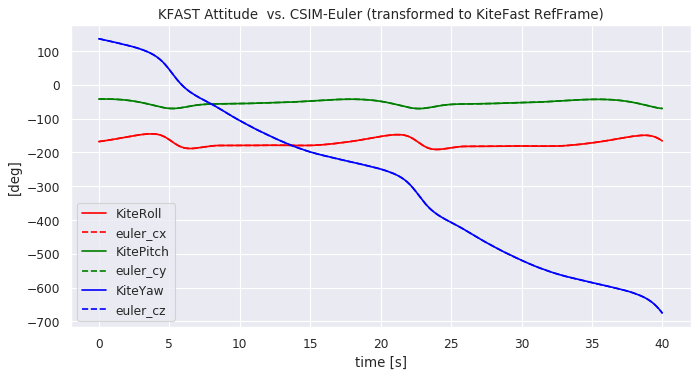

In [283]:
if injupyter:
    %matplotlib inline

fig= plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
for ii in range(0,3):
    
    ax.plot(time_k[idx_k],np.rad2deg(np.unwrap(Att_rad_k[:,ii])),label=Att_df_k.columns[ii],color=colors[ii])
    ax.plot(time_c2k,np.rad2deg(np.unwrap(euler_c2k[:,ii])),label='euler_c'+coords[ii],color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('[deg]')
ax.set_title('KFAST Attitude  vs. CSIM-Euler (transformed to KiteFast RefFrame)')
plt.legend(loc='best')
plt.show()

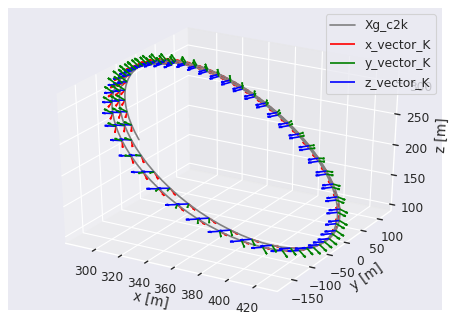

In [284]:
#3D 
if injupyter:
    from importlib import reload
    reload(plt)
    %matplotlib inline
#from importlib import reload
#reload(plt)
#%matplotlib notebook 
#%matplotlib notebook 
#%matplotlib notebook 

#3 times is a charm.... needed

fig= plt.figure(figsize=(7, 5), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.plot3D(Xg_c2k[::decimation,0],Xg_c2k[::decimation,1],Xg_c2k[::decimation,2], 'gray',label='Xg_c2k')

for ii in range(0,3):
    ax1.quiver(Xg_k[::2*decimation,0],Xg_k[::2*decimation,1],Xg_k[::2*decimation,2], \
               dcm_fromatt_k[::2*decimation,ii,0], dcm_fromatt_k[::2*decimation,ii,1], dcm_fromatt_k[::2*decimation,ii,2],\
               label=coords[ii]+'_vector_K',length=10,color=colors[ii])

ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_zlabel('z [m]')
ax.set_title('KFAST triads overlaid on CSIM-Xg (transformed to KiteFast RefFrame)')
plt.legend(loc='best')
plt.show()

(2000, 3) (2001, 3) 0.002 [0.]


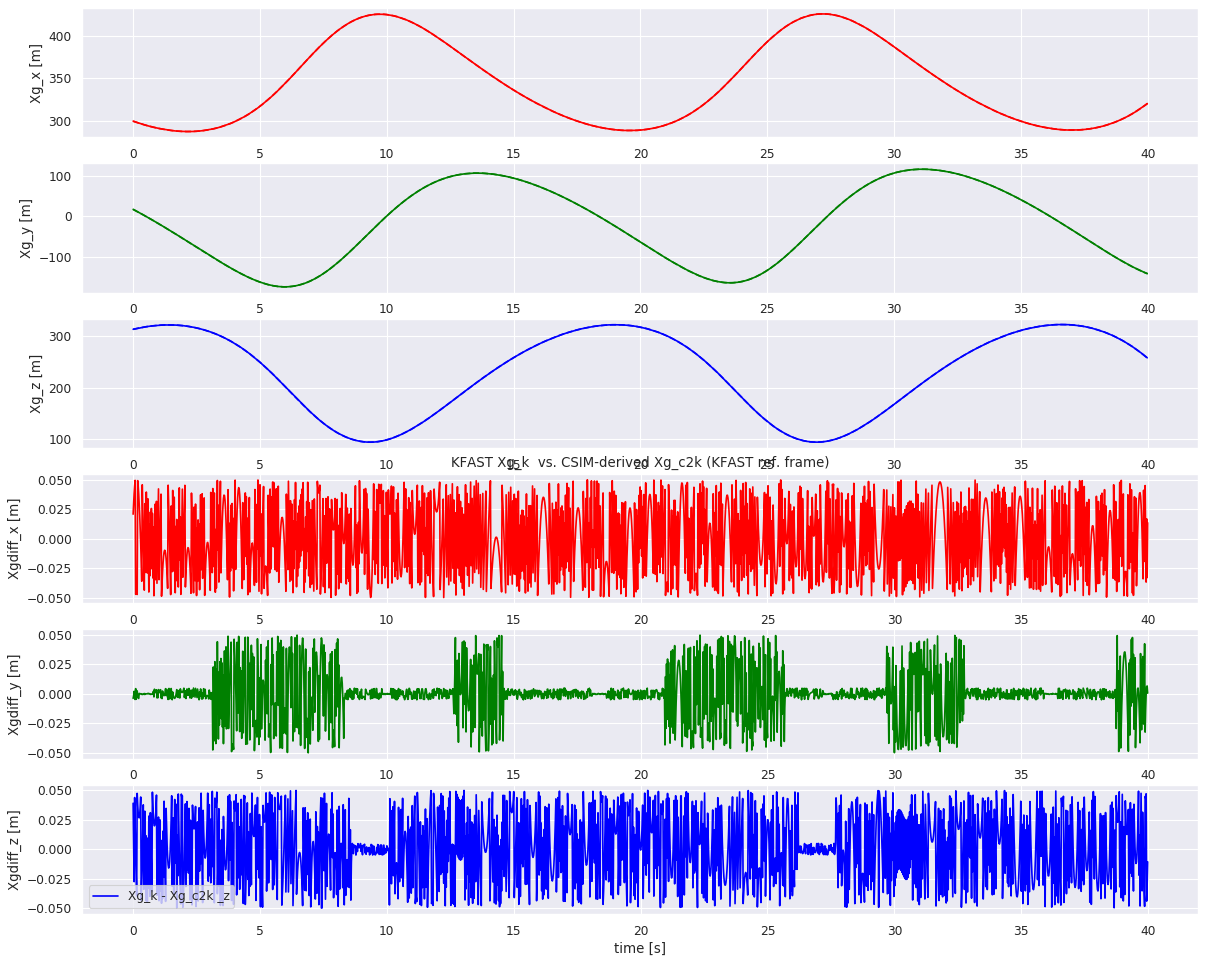

In [285]:
#Plotting Xg you can see some differences let us analyze them => no real differences, good.
print(Xg_k.shape,Xg_c2k.shape,time_k[idx_k][0],time_c2k[0])

if injupyter:
    from importlib import reload
    reload(plt)
    %matplotlib inline

ax=[None]*3
fig= plt.figure(figsize=(18, 15), dpi= 80, facecolor='w', edgecolor='k')

for ii in range(0,3):
  ax[ii] = fig.add_subplot(6, 1, ii+1) 
  ax[ii].plot(time_k[idx_k],Xg_k[:,ii],label='Xg_k_'+coords[ii], color=colors[ii])
  ax[ii].plot(time_c2k[:],Xg_c2k[:,ii],label='Xg_c2k_'+coords[ii], color=colors[ii],linestyle='--')
  ax[ii].set_xlabel('time [s]')
  ax[ii].set_ylabel('Xg_'+coords[ii]+' [m]')

for ii in range(0,3):
  ax[ii] = fig.add_subplot(6, 1, ii+4) 
  ax[ii].plot(time_k[idx_k],Xg_k[:,ii]-Xg_c2k[:-1,ii],label='Xg_k - Xg_c2k _'+coords[ii], color=colors[ii])
  ax[ii].set_xlabel('time [s]')
  ax[ii].set_ylabel('Xgdiff_'+coords[ii]+' [m]')



ax[0].set_title('KFAST Xg_k  vs. CSIM-derived Xg_c2k (KFAST ref. frame)')

plt.legend(loc='best')
plt.show()

# Check Wind Velocity and Kite Velocity

In [286]:
# Wind in ground coordinates
windvelstr=np.core.defchararray.add(np.tile('Wind1Vel',ncoords),[x.upper() for x in coords])
windvelstr
wind_g_k=df.loc[idx_k,windvelstr].to_numpy('float')
wind_g_k.shape,dcm_fromatt_k.shape, windvelstr

((2000, 3),
 (2000, 3, 3),
 array(['Wind1VelX', 'Wind1VelY', 'Wind1VelZ'], dtype='<U9'))

In [287]:
#Vb_k In body coordinate system
KiteVelstr=np.core.defchararray.add(np.tile('KiteTV',ncoords),coords)
KiteVelstr
Vb_k=df.loc[idx_k,KiteVelstr].to_numpy('float')
Vb_k,Vb_k.shape

(array([[ 0.   ,  0.   ,  0.   ],
        [35.27 , -7.536, -6.544],
        [35.27 , -7.558, -6.55 ],
        ...,
        [51.58 , -4.183, -9.881],
        [51.71 , -4.11 , -9.872],
        [51.85 , -4.035, -9.862]]), (2000, 3))

In [288]:
#There is no direct output for Vg_k or DCMg2b in KFAST, so I need to reconstrauct them from DCM and Vb
Vg_k=np.einsum('kij,kj->ki', dcm_fromatt_k.transpose([0,2,1]), Vb_k)  #this is the way i managed to get matmul to work with 3d x 2d arrays
#since j disappears, it is summed upon
Vg_k.shape, dcm_fromatt_k.transpose([0,2,1]).shape, Vb_k.shape, Vg_k

((2000, 3),
 (2000, 3, 3),
 (2000, 3),
 array([[  0.        ,   0.        ,   0.        ],
        [-10.48593287, -33.09198856,  11.7708809 ],
        [-10.39641877, -33.20031106,  11.56082117],
        ...,
        [ 22.31485313, -25.36895021, -40.42390066],
        [ 22.49236385, -25.00313701, -40.70883555],
        [ 22.67221453, -24.7125306 , -40.95392885]]))

In [289]:
## Update 1/24/20 I have added some output now for instance KiteTVx-zi
KiteVelistr=np.core.defchararray.add(np.tile('KiteTV',ncoords),np.core.defchararray.add(coords,np.tile('i',ncoords)))
KiteVelistr
Vg2_k=df.loc[idx_k,KiteVelistr].to_numpy('float')
np.linalg.norm(Vg2_k[0:10],axis=1)

array([ 0.        , 36.65062073, 36.66148115, 36.67022907, 36.6831419 ,
       36.69402676, 36.70600087, 36.71230045, 36.72611862, 36.74388379])

In [290]:
#double check:
np.matmul(dcm_fromatt_k[1,:,:].transpose(),Vb_k[1,:].T)

array([-10.48593287, -33.09198856,  11.7708809 ])

In [291]:
#omega_k   :   In body coordinate system (i.e. pqr)
Kiteomgstr=np.core.defchararray.add(np.tile('KiteRV',ncoords),coords)
Kiteomgstr
omega_k=np.deg2rad(df.loc[idx_k,Kiteomgstr].to_numpy('float'))
omega_k,omega_k.shape

(array([[ 0.        ,  0.        ,  0.        ],
        [-0.04513421, -0.06082472, -0.22794   ],
        [-0.04565781, -0.06077236, -0.22811453],
        ...,
        [-0.16509069,  0.07309439, -0.45971972],
        [-0.1640784 ,  0.07422885, -0.46094146],
        [-0.16306611,  0.07532841, -0.46216319]]), (2000, 3))

In [292]:
# Apparent Wind in body coordinates: It does not come out automatically from KFAST so build it
apparent_wind_b_vec_k=np.einsum('kij,kj->ki', mipdcm_k,wind_g_k) - Vb_k  #this is the way i managed to get matmul to work with 3d x 2d arrays
#since j disappears, it is summed upon
apparent_wind_b_vec_k


array([[ -6.3996,  -6.144 ,  -8.0796],
       [-41.6516,   1.3692,  -1.5332],
       [-41.6336,   1.3696,  -1.526 ],
       ...,
       [-48.7924,   1.1698,  -1.3954],
       [-48.878 ,   1.1604,  -1.4104],
       [-48.9748,   1.149 ,  -1.4252]])

In [293]:
Vb_k.shape, len(idx_k)
#Set max length to use in case the simulation crashed
c_maxidx=len(idx_k)

In [294]:
apparent_wind_b_y_ktest=apparent_wind_b_vec_k[:,1]+Vb_k[:,1] -Vb_c2k[:c_maxidx,1]

### Then to be consistent with CSIM, we should calculate Magnitude, AOA (alpha) and beta#

In [295]:
apparent_wind_b_k=np.zeros_like(apparent_wind_b_vec_k)
apparent_wind_b_k[:,0]=np.linalg.norm(apparent_wind_b_vec_k,axis=1)
apparent_wind_b_k[:,1]=np.arctan(apparent_wind_b_vec_k[:,2]/apparent_wind_b_vec_k[:,0])
# I have been playing with Vb_y, because it looks wrong from KFAST
apparent_wind_b_k[:,2]=np.arctan(apparent_wind_b_vec_k[:,1]/apparent_wind_b_vec_k[:,0])
apparent_wind_b_k[:,2]=-np.arcsin(apparent_wind_b_vec_k[:,1]/np.linalg.norm(apparent_wind_b_vec_k,axis=1))
#apparent_wind_b_k[:,2]=np.arcsin(-apparent_wind_b_y_ktest/np.sqrt(np.sum(apparent_wind_b_k[:,0:2]**2,axis=1)))
dcm_fromatt_k.shape, wind_g_k.shape,time_k.shape,
np.rad2deg(apparent_wind_b_k),np.rad2deg(apparent_wind_b_c)

(array([[ 6.87510087e+02,  5.16183497e+01,  3.07990914e+01],
        [ 2.38936535e+03,  2.10811217e+00, -1.88151486e+00],
        [ 2.38832090e+03,  2.09912756e+00, -1.88288808e+00],
        ...,
        [ 2.79754462e+03,  1.63813923e+00, -1.37284472e+00],
        [ 2.80245755e+03,  1.65284075e+00, -1.35942324e+00],
        [ 2.80800906e+03,  1.66687574e+00, -1.34340383e+00]]),
 array([[ 2.38972625e+03,  2.14904360e+00, -2.01096103e+00],
        [ 2.38888779e+03,  2.13936212e+00, -2.01222348e+00],
        [ 2.38806473e+03,  2.12976833e+00, -2.01358544e+00],
        ...,
        [ 2.80533029e+03,  1.61859609e+00, -1.61253959e+00],
        [ 2.81047370e+03,  1.63234958e+00, -1.59844601e+00],
        [ 2.81563144e+03,  1.64637607e+00, -1.58450621e+00]]))

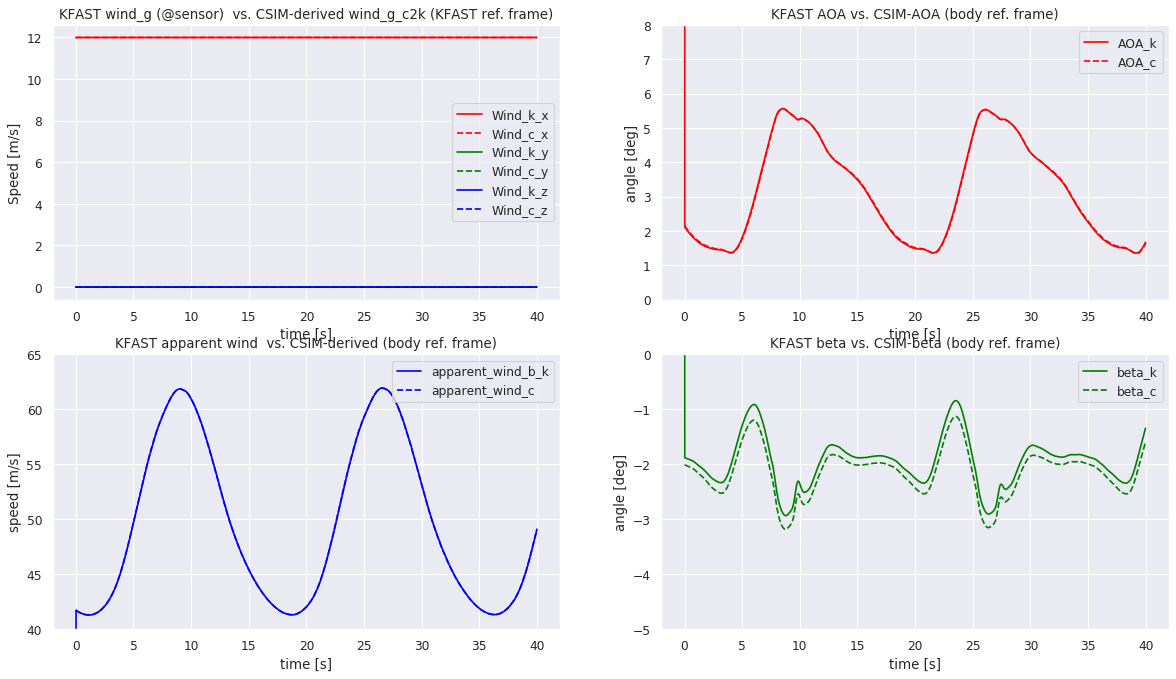

In [296]:
#Plot windvel & apparent wind: 1st CSIM derived (in KFAST ref frame) vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook

fig= plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(2, 2, 1)
for ii in range(0,3):
    ax.plot(time_k[idx_k],wind_g_k[:,ii],label='Wind_k_'+coords[ii], color=colors[ii])
    ax.plot(time_c2k,wind_g_c2k[:,ii],label='Wind_c_'+coords[ii], color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('Speed [m/s]')
ax.set_title('KFAST wind_g (@sensor)  vs. CSIM-derived wind_g_c2k (KFAST ref. frame)')
plt.legend(loc='best')
#_____________
ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(time_k[idx_k],apparent_wind_b_k[:,0],label='apparent_wind_b_k', color=colors[ii])
ax2.plot(time_c2k,apparent_wind_b_c[:,0],label='apparent_wind_c', color=colors[ii],linestyle='--') #,marker='o'

ax2.set_xlabel('time [s]')
ax2.set_ylabel('speed [m/s]')
ax2.set_title('KFAST apparent wind  vs. CSIM-derived (body ref. frame)')
ax2.set_ylim(40,65)
plt.legend(loc='best')

#_____________
ax3 = fig.add_subplot(2, 2, 2)

ax3.plot(time_k[idx_k],np.rad2deg(apparent_wind_b_k[:,1]),label='AOA_k', color=colors[0])
ax3.plot(time_c2k,np.rad2deg(apparent_wind_b_c[:,1]),label='AOA_c', color=colors[0],linestyle='--')#,marker='o'

ax3.set_title('KFAST AOA vs. CSIM-AOA (body ref. frame)')
ax3.set_xlabel('time [s]')
ax3.set_ylabel('angle [deg]')
ax3.set_ylim(0,8)
plt.legend(loc='best')

#_____________
ax4 = fig.add_subplot(2, 2, 4)

ax4.plot(time_k[idx_k],np.rad2deg(apparent_wind_b_k[:,2]),label='beta_k', color=colors[1])
ax4.plot(time_c2k,np.rad2deg(apparent_wind_b_c[:,2]),label='beta_c', color=colors[1],linestyle='--')

ax4.set_xlabel('time [s]')
ax4.set_ylabel('angle [deg]')
ax4.set_title('KFAST beta vs. CSIM-beta (body ref. frame)')
ax4.set_ylim(-5,0)
plt.legend(loc='best')

plt.show()

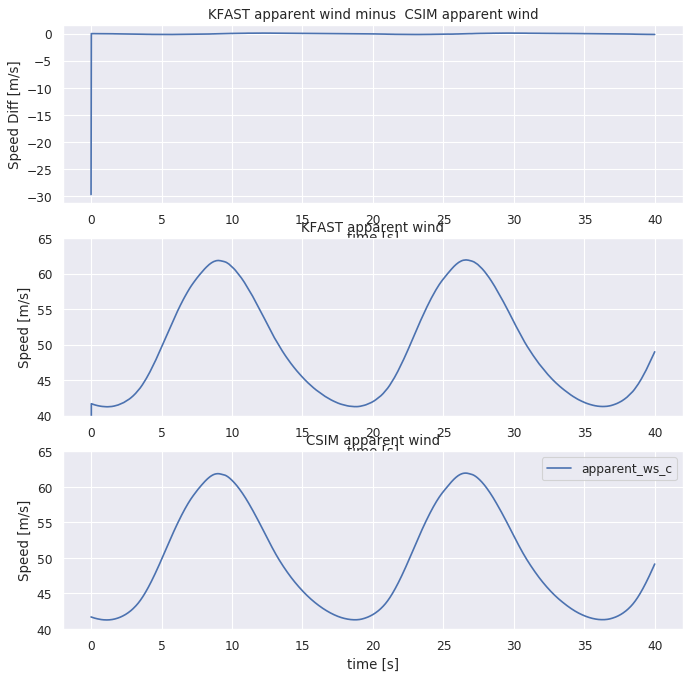

In [297]:
#Difference in magnitude of apparent winds
fig= plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(3, 1, 1)
ax.plot(time_k[idx_k],apparent_wind_b_k[:,0]-apparent_wind_b_c[1:c_maxidx+1,0],label='apparent_ws_diff')
ax.set_xlabel('time [s]')
ax.set_ylabel('Speed Diff [m/s]')
ax.set_title('KFAST apparent wind minus  CSIM apparent wind')

ax = fig.add_subplot(3, 1, 2)
ax.plot(time_k[idx_k],apparent_wind_b_k[:,0],label='apparent_ws_k')
ax.set_xlabel('time [s]')
ax.set_ylabel('Speed [m/s]')
ax.set_title('KFAST apparent wind')
ax.set_ylim(40,65)

ax = fig.add_subplot(3, 1, 3)
ax.plot(time_k[idx_k],apparent_wind_b_c[1:c_maxidx+1,0],label='apparent_ws_c')
ax.set_xlabel('time [s]')
ax.set_ylabel('Speed [m/s]')
ax.set_title('CSIM apparent wind')
ax.set_ylim(40,65)

plt.legend(loc='best')
plt.show()

## Note: The initial velocity in KFAST MIP is 0 due to the constraint run, it is not set to 0 for unconstrained runs

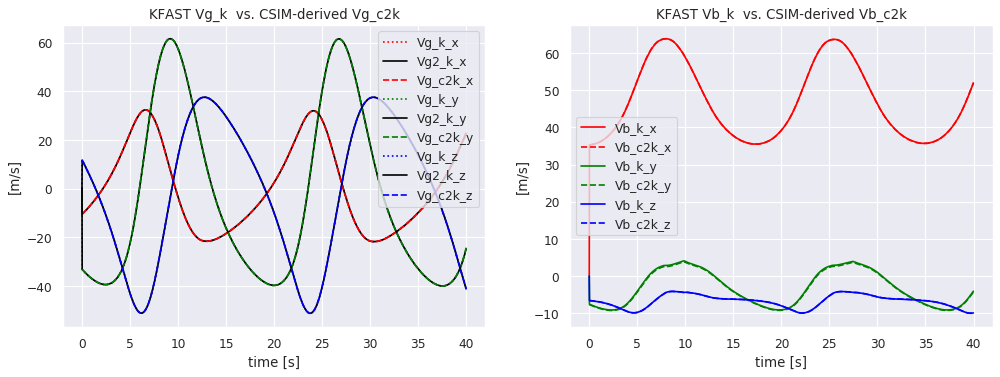

In [298]:
#Plot kite vels w.r.t. ground and body: 1st CSIM derived (in KFAST ref frame) vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook

fig= plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 2, 1)
 
for ii in range(0,3):
    ax.plot(time_k[idx_k],Vg_k[:,ii],label='Vg_k_'+coords[ii],color=colors[ii],linestyle=':')
    ax.plot(time_k[idx_k],Vg2_k[:,ii],label='Vg2_k_'+coords[ii],color='black')
    ax.plot(time_c2k,Vg_c2k[:,ii],label='Vg_c2k_'+coords[ii],color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('[m/s]')
ax.set_title('KFAST Vg_k  vs. CSIM-derived Vg_c2k')
plt.legend(loc='best')

#in body coordinates
ax1 = fig.add_subplot(1, 2, 2)

for ii in range(0,3):
    ax1.plot(time_k[idx_k],Vb_k[:,ii],label='Vb_k_'+coords[ii],color=colors[ii])
    ax1.plot(time_c2k,Vb_c2k[:,ii],label='Vb_c2k_'+coords[ii],color=colors[ii],linestyle='--')

ax1.set_xlabel('time [s]')
ax1.set_ylabel('[m/s]')
ax1.set_title('KFAST Vb_k  vs. CSIM-derived Vb_c2k')
plt.legend(loc='best')
plt.show()


IMU[ii] location is 0.390
IMU[ii] location is 0.085
IMU[ii] location is 0.534


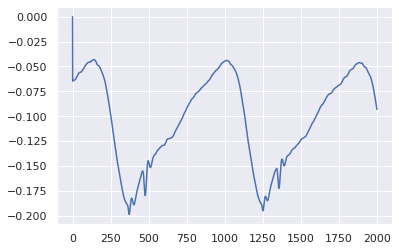

In [299]:
#To test Vby, let us add the actual IMU location and the effect of the omega
IMUs=np.zeros([3,1])

for ii in range(0,3):
    IMUs[ii]=log['parameters']['system_params']['wing_imus']['pos'][0][coords[ii]][0]
    print('IMU[ii] location is {:5.3f}'.format(*IMUs[ii]))
vtimu=np.cross(omega_k,IMUs.reshape(1,3),axis=1)
plt.figure()
#plt.plot(time_k[idx_k],Vb_k[:,1])
plt.plot(vtimu[:,1])
#plt.legend(loc='best')
plt.show()

-51.13 -9.954246217034115
time_k[idx_k[0]]=0.002
[0.002 0.022 0.042 0.062 0.082 0.102 0.122 0.142 0.162 0.182]
[[0.  ]
 [0.02]
 [0.04]
 [0.06]
 [0.08]
 [0.1 ]
 [0.12]
 [0.14]
 [0.16]
 [0.18]]


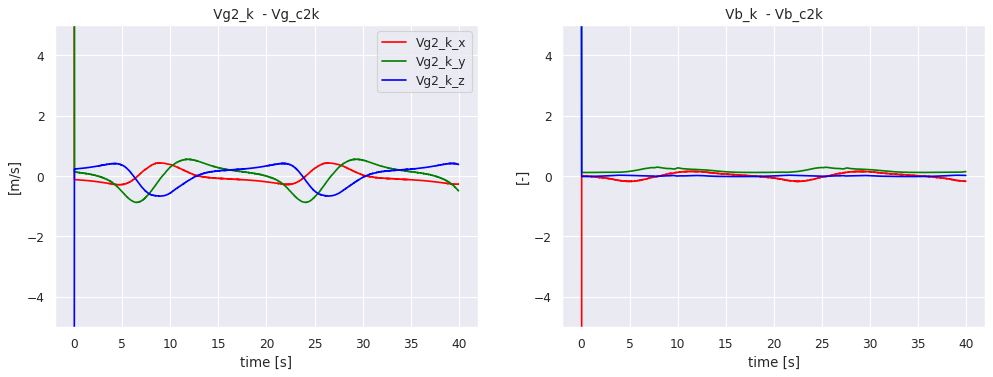

In [300]:
# Really strange that Vgs are right on and not so much in Vb (y component), let us replot as difference
#That means I need to bring them to the same time scale... UPDATE 2/2020: This is now fixed, the problem was with MIP node in .mbd inputfile pointing to the wrong node
Vg2_k.shape,Vg_c2k.shape
#Sart Vg_c2k at 1 rather than 0 and things will be acceptable. Furthermore, since they cross zero add a constant to all
minval_b=np.min(Vb_c2k)
minval_g=np.min(Vg2_k)
print(minval_g, minval_b)
print('time_k[idx_k[0]]={:5.3f}'.format(time_k[idx_k[0]]))
print(time_k[idx_k[0:10]])
print(time_c2k[0:10])
if injupyter:
    %matplotlib inline 
#notebook

fig= plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 2, 1)
 
for ii in range(0,3):
    ax.plot(time_k[idx_k],np.roll(Vg2_k[:,ii],0)-Vg_c2k[1:c_maxidx+1,ii],label='Vg2_k_'+coords[ii],color=colors[ii])

    ax.set_xlabel('time [s]')
    ax.set_ylabel('[m/s]')
    ax.set_title(' Vg2_k  - Vg_c2k ')
    ax.set_ylim([-5,5])
    plt.legend(loc='best')

#in body coordinates
ax1 = fig.add_subplot(1, 2, 2)

for ii in range(0,3):
    ax1.plot(time_k[idx_k],np.roll(Vb_k[:,ii],0)-Vb_c2k[1:c_maxidx+1,ii],label='Vb_'+coords[ii],color=colors[ii])
   
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('[-]')
    ax1.set_title(' Vb_k  - Vb_c2k ')
    ax1.set_ylim([-5,5])
##plt.legend(loc='best')
##plt.show()

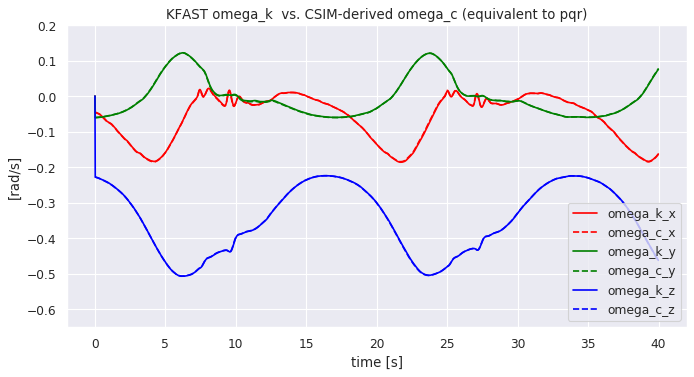

In [301]:
#Plot kite pqr w.r.t. body: 1st CSIM derived (in KFAST ref frame) vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook

fig= plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
 
for ii in range(0,3):
    ax.plot(time_k[idx_k],omega_k[:,ii],label='omega_k_'+coords[ii],color=colors[ii])
    ax.plot(time_c2k,omega_c[:,ii],label='omega_c_'+coords[ii],color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('[rad/s]')
ax.set_ylim(-0.65,0.2)
ax.set_title('KFAST omega_k  vs. CSIM-derived omega_c (equivalent to pqr)')
plt.legend(loc='best')

plt.show()

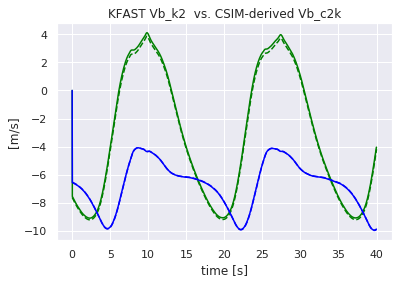

In [302]:
Vb_k2=np.einsum('kij,kj->ki', dcm_fromatt_k,Vg_k)
Vb_k2.shape
%matplotlib inline
plt.figure()

for ii in range(1,3):
    plt.plot(time_k[idx_k],Vb_k2[:,ii],label='Vb_k2_'+coords[ii],color=colors[ii])
    plt.plot(time_c2k,Vb_c2k[:,ii],label='Vb_c2k_'+coords[ii],color=colors[ii],linestyle='--')

plt.xlabel('time [s]')
plt.ylabel('[m/s]')
plt.title('KFAST Vb_k2  vs. CSIM-derived Vb_c2k')
#plt.legend(loc='best')
plt.show()

In [303]:
#Ab_k In body coordinate system
KiteAccstr=np.core.defchararray.add(np.tile('KiteTA',ncoords),coords)
KiteAccstr
Ab_k=df.loc[idx_k,KiteAccstr].to_numpy('float')
Ab_k,Ab_k.shape

(array([[ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 1.427e-06, -6.004e-06,  3.347e-06],
        [ 1.476e-06, -5.982e-06,  3.400e-06],
        ...,
        [ 2.669e-04, -1.157e-03,  6.137e-04],
        [ 2.689e-04, -1.167e-03,  6.184e-04],
        [ 2.019e-05, -9.898e-05,  4.634e-05]]), (2000, 3))

In [304]:
#Ag_k In KFAST coordinate system
##There is no direct output for Ag_k or DCMg2b in KFAST, so I need to reconstruct them from DCM and Ab
##Ag_k=np.einsum('kij,kj->ki', dcm_fromatt_k.transpose([0,2,1]), Ab_k)  #this is the way i managed to get matmul to work with 3d x 2d arrays
##since j disappears, it is summed upon
#Updated In Feb/2020, as now I have added KiteTAxi
junk=np.core.defchararray.add(coords,np.tile('i',ncoords))
KiteAccstr2=np.core.defchararray.add(np.tile('KiteTA',ncoords),junk)
print(KiteAccstr2)
Ag_k=df.loc[idx_k,KiteAccstr2].to_numpy('float')
Ag_norm_k=np.linalg.norm(Ag_k,axis=1)
Ag_k.shape, Ab_k.shape, Ag_k[0:15,:]

['KiteTAxi' 'KiteTAyi' 'KiteTAzi']


((2000, 3), (2000, 3), array([[ 0.000e+00,  0.000e+00,  0.000e+00],
        [ 7.357e-08, -4.234e-06, -5.600e-06],
        [ 1.370e-08, -4.227e-06, -5.626e-06],
        [-2.932e-06, -4.475e-05, -6.138e-05],
        [-3.532e-06, -4.462e-05, -6.185e-05],
        [-3.603e-06, -4.466e-05, -6.253e-05],
        [-3.220e-06, -4.477e-05, -6.355e-05],
        [-3.501e-06, -4.471e-05, -6.386e-05],
        [-2.975e-06, -4.475e-05, -6.459e-05],
        [-3.185e-06, -4.456e-05, -6.448e-05],
        [-3.515e-06, -4.473e-05, -6.592e-05],
        [-3.211e-06, -4.450e-05, -6.579e-05],
        [-3.011e-06, -4.479e-05, -6.713e-05],
        [-2.862e-06, -4.454e-05, -6.707e-05],
        [-3.069e-06, -4.449e-05, -6.759e-05]]))

In [305]:
Ab_c2k[0,:]

array([-1.15392349, -9.43911201,  2.20878391])

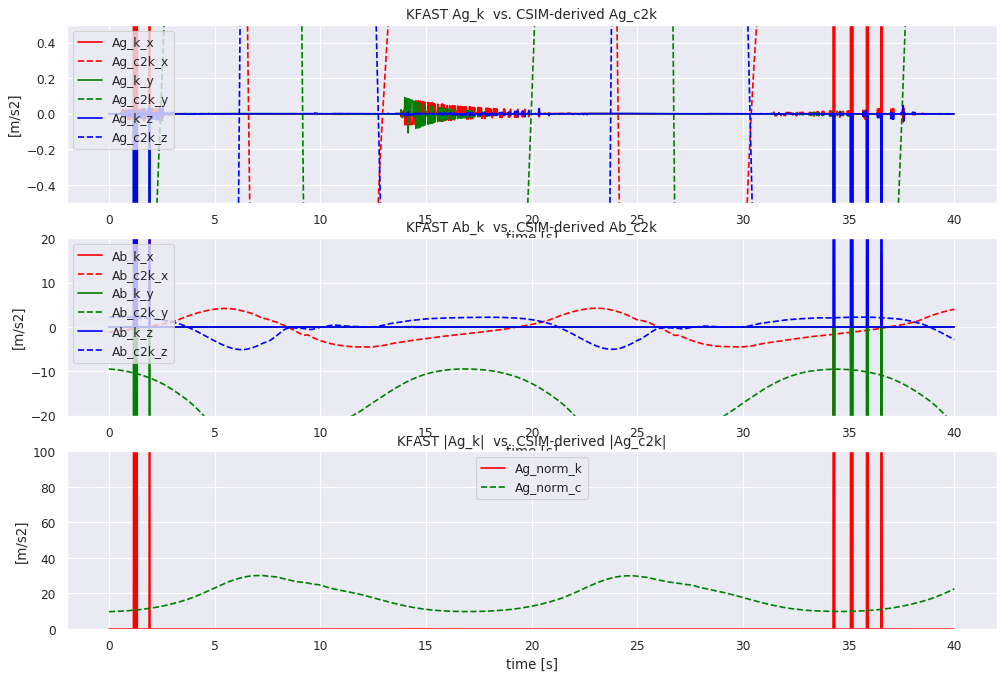

In [306]:
#Plot kite Accels w.r.t. ground and body: 1st CSIM derived (in KFAST ref frame) vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook

fig= plt.figure(figsize=(15, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(3, 1, 1)
 
for ii in range(0,3):
    ax.plot(time_k[idx_k],Ag_k[:,ii],label='Ag_k_'+coords[ii],color=colors[ii])
    ax.plot(time_c2k,Ag_c2k[:,ii],label='Ag_c2k_'+coords[ii],color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('[m/s2]')
ax.set_title('KFAST Ag_k  vs. CSIM-derived Ag_c2k')
plt.legend(loc='best')
ax.set_ylim([-0.5,0.5])

#in body coordinates
ax1 = fig.add_subplot(3, 1, 2)

for ii in range(0,3):
    ax1.plot(time_k[idx_k],Ab_k[:,ii],label='Ab_k_'+coords[ii],color=colors[ii])
    ax1.plot(time_c2k,Ab_c2k[:,ii],label='Ab_c2k_'+coords[ii],color=colors[ii],linestyle='--')

ax1.set_xlabel('time [s]')
ax1.set_ylabel('[m/s2]')
ax1.set_title('KFAST Ab_k  vs. CSIM-derived Ab_c2k')
plt.legend(loc='best')
ax1.set_ylim([-20,20])
#in magnitude
ax2 = fig.add_subplot(3, 1, 3)

ax2.plot(time_k[idx_k],Ag_norm_k,label='Ag_norm_k',color=colors[0])
ax2.plot(time_c2k,Ag_norm_c,label='Ag_norm_c',color=colors[1],linestyle='--')

ax2.set_xlabel('time [s]')
ax2.set_ylabel('[m/s2]')
ax2.set_title('KFAST |Ag_k|  vs. CSIM-derived |Ag_c2k|')
plt.legend(loc='best')
ax2.set_ylim([-0,100])

plt.show()

# AeroTorques, Rotor Speeds, Vrels@rotor, Skew Angles, Thrusts, & Generator Torques

In [307]:
# KFAST AeroTorques SP1TMX...PP2BMX
# We will arrange in CSIM order !!!
aeroTorquestr=['SP2BMX', 'SP1BMX', 'PP1BMX', 'PP2BMX', 'PP2TMX', 'PP1TMX','SP1TMX','SP2TMX'] #initialize
rotspeedstr= [s[:-2]+'RTSPD' for s in aeroTorquestr] 
vrotstr= [s[:-2]+'Vrel' for s in aeroTorquestr] 
skewstr= [s[:-2]+'Skew' for s in aeroTorquestr] 
Fxrotstr= [s[:-2]+'Fx' for s in aeroTorquestr] 
Fyrotstr= [s[:-2]+'Fy' for s in aeroTorquestr] 
Fzrotstr= [s[:-2]+'Fz' for s in aeroTorquestr] 

#
aeroTorque_df_k=df.loc[idx_k,aeroTorquestr].astype('float')
aeroTorque_df_k.describe()

rotspeed_df_k=df.loc[idx_k,rotspeedstr].astype('float')
rotspeed_df_k.describe()

vrot_df_k=df.loc[idx_k,vrotstr].astype('float')
vrot_df_k.describe()

chi_df_k=df.loc[idx_k,skewstr].astype('float')
chi_df_k.describe()

rotFx_df_k=df.loc[idx_k,Fxrotstr].astype('float')
rotFx_df_k.describe()

rotFy_df_k=df.loc[idx_k,Fyrotstr].astype('float')
rotFy_df_k.describe()

rotFz_df_k=df.loc[idx_k,Fzrotstr].astype('float')
rotFz_df_k.describe()


SP2BFz       SP1BFz       PP1BFz       PP2BFz       PP2TFz  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean     44.094132    50.676600    52.643800    47.905091    66.578503   
std      22.253291    30.331872    31.749482    27.105674    34.967914   
min       3.238000    15.310000    15.040000     0.428200     4.216000   
25%      25.537500    26.050000    26.120000    25.727500    38.595000   
50%      41.225000    37.880000    39.165000    37.710000    54.190000   
75%      58.040000    71.427500    74.622500    65.692500    92.615000   
max     100.900000   122.000000   125.600000   111.100000   146.000000   

            PP1TFz       SP1TFz       SP2TFz  
count  2000.000000  2000.000000  2000.000000  
mean     71.734000    67.771985    57.427536  
std      36.110333    33.811617    26.111577  
min      18.290000    24.800000     6.853000  
25%      39.810000    38.245000    34.885000  
50%      63.020000    60.540000    53.645000  
75%      97.712500    90.497500    71.237500  
max     152.100000   145.500000   120.700000

In [308]:
# KFAST GenTorques: They need to come from KiteFAST.KFC.out
#Note in KiteFAST.KFC.out the generator torques are ordered 1--8 following CSIM already (supposedly)
# We will arrange in CSIM order !!!
ctr=np.linspace(1,nmotors,nmotors,dtype=int).astype('str')
genTorquestr=np.core.defchararray.add(np.tile('Rot',nmotors),ctr)
genTorquestr=np.core.defchararray.add(genTorquestr,np.tile('GTq',nmotors))                           
genTorquestr

array(['Rot1GTq', 'Rot2GTq', 'Rot3GTq', 'Rot4GTq', 'Rot5GTq', 'Rot6GTq',
       'Rot7GTq', 'Rot8GTq'], dtype='<U27')

In [309]:
# KFAST GenTorques: They need to come from KiteFAST.KFC.out
# (there is no gearbox)
# It has its own time step so cannot use idx_k <<<<!<<<<<
time_kfc=df_kfc.loc[1:,'Time'].values.astype('float')
gen_torque_df_k=df_kfc.loc[1:,genTorquestr].astype('float')

gen_torque_df_k.describe()

Rot1GTq      Rot2GTq      Rot3GTq      Rot4GTq      Rot5GTq  \
count  2001.000000  2001.000000  2001.000000  2001.000000  2001.000000   
mean    203.435809  -281.996967  -301.949140   319.291019  -236.723289   
std     240.687146   282.629117   284.501983   287.838891   269.293563   
min    -105.200000  -759.300000  -791.800000   -92.970000  -638.600000   
25%     -12.850000  -550.500000  -552.000000    27.330000  -519.700000   
50%     146.600000  -230.800000  -302.700000   367.000000  -237.100000   
75%     417.100000    -0.301400   -13.760000   563.100000    37.430000   
max     711.600000   100.500000    96.150000   827.300000   150.000000   

           Rot6GTq      Rot7GTq      Rot8GTq  
count  2001.000000  2001.000000  2001.000000  
mean    179.221531   170.585544  -165.244877  
std     238.141843   239.308816   242.684093  
min    -152.000000  -155.200000  -632.600000  
25%     -47.380000   -57.730000  -367.300000  
50%     170.600000   147.500000  -136.500000  
75%     378.400000   372.200000    66.910000  
max     651.700000   626.700000   159.500000

In [310]:
rotspeed_df_k.head(12)

SP2BRTSPD  SP1BRTSPD  PP1BRTSPD  PP2BRTSPD  PP2TRTSPD  PP1TRTSPD  \
1       -147.0      145.0      142.8     -140.7      164.8     -166.7   
11      -147.0      145.0      142.8     -140.7      164.8     -166.7   
21      -146.9      144.8      142.7     -140.5      164.6     -166.5   
31      -146.7      144.6      142.5     -140.3      164.4     -166.3   
41      -146.6      144.4      142.3     -140.1      164.2     -166.1   
51      -146.4      144.3      142.1     -139.8      164.0     -165.9   
61      -146.3      144.1      141.9     -139.6      163.7     -165.7   
71      -146.1      143.9      141.6     -139.4      163.5     -165.6   
81      -145.9      143.7      141.4     -139.2      163.3     -165.4   
91      -145.7      143.5      141.2     -138.9      163.1     -165.2   
101     -145.5      143.3      141.0     -138.6      162.8     -164.9   
111     -145.4      143.1      140.8     -138.4      162.6     -164.7   

     SP1TRTSPD  SP2TRTSPD  
1       -168.5      170.3  
11      -168.5      170.3  
21      -168.3      170.2  
31      -168.2      170.0  
41      -168.0      169.8  
51      -167.8      169.7  
61      -167.7      169.5  
71      -167.5      169.4  
81      -167.3      169.2  
91      -167.1      169.0  
101     -166.9      168.9  
111     -166.8      168.7

In [311]:
aeroTorque_k=aeroTorque_df_k.to_numpy('float')
rot_speed_k=rotspeed_df_k.to_numpy('float')
gen_torque_k=gen_torque_df_k.to_numpy('float')
#
vrot_k=vrot_df_k.to_numpy('float')
chi_k=chi_df_k.to_numpy('float')
rot_thrust_k=rotFx_df_k.to_numpy('float')

aeroTorque_k.shape,rot_speed_k.shape,gen_torque_k.shape,vrot_k.shape,chi_k.shape, rot_thrust_k.shape

((2000, 8), (2000, 8), (2001, 8), (2000, 8), (2000, 8), (2000, 8))

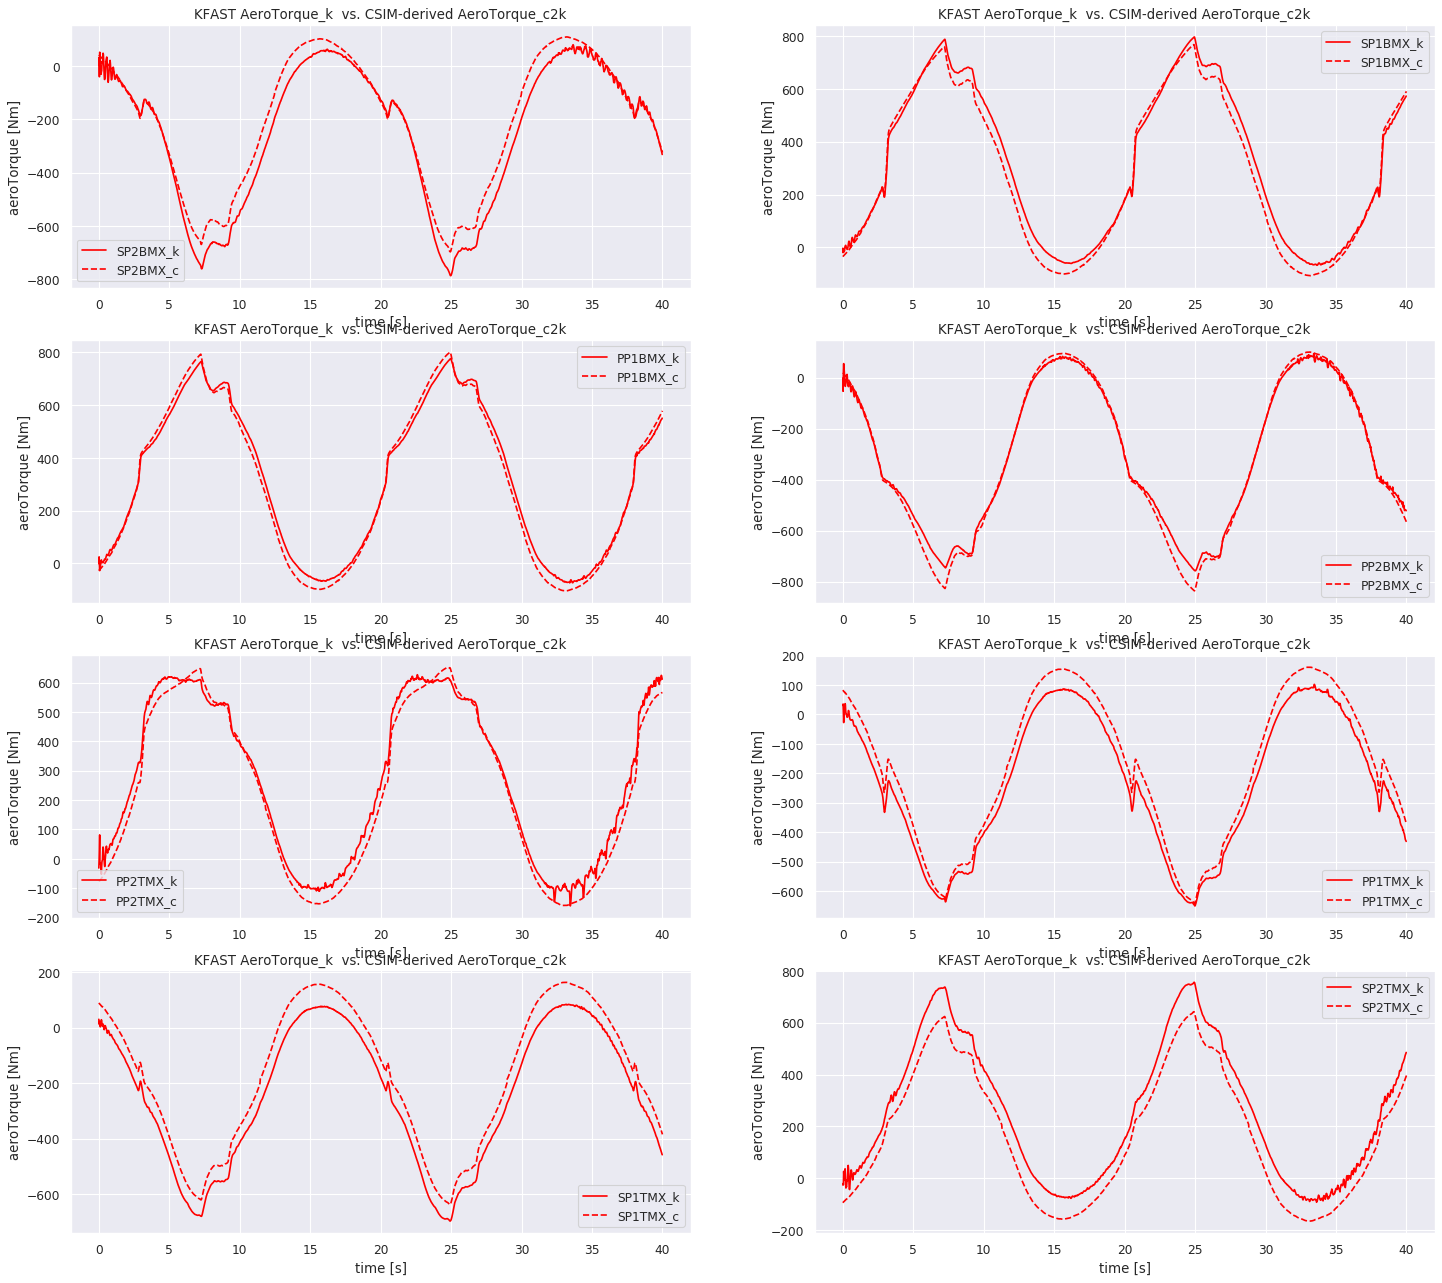

In [312]:
#Plot Aerotroques: 1st CSIM derived  vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(22, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_k[idx_k],aeroTorque_k[:,irot],label=aeroTorquestr[irot]+'_k',color='red')
    ax[irot].plot(time_c2k,aero_torque_c[:,irot],label=aeroTorquestr[irot]+'_c',color='red',linestyle='--')
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('aeroTorque [Nm]')
    ax[irot].set_title('KFAST AeroTorque_k  vs. CSIM-derived AeroTorque_c2k')
    plt.legend(loc='best')

plt.show()

In [313]:
#Get commanded Speed from STI
nmotstr=np.linspace(0,nmotors-1,nmotors)
nmotstr=[str(int(s)) for s in nmotstr]
rotspd_STI_str=np.core.defchararray.add(np.tile('rotors[',nmotors),np.core.defchararray.add(nmotstr, np.tile(']',nmotors)))

time_STI =df_STI['time'].to_numpy()
rot_speed_STI=df_STI[rotspd_STI_str].to_numpy()
rot_speed_STI.shape
rot_speed_STI[0:10,0]

array([-142.368521, -140.142127, -143.751181, -148.383465, -153.073185,
       -157.20802 , -160.634406, -163.719905, -166.834991, -170.029048])

In [314]:
aa=rot_speed_STI[::2,0]
aa[0:12],rot_speed_k[0:12,0]

(array([-142.368521, -143.751181, -153.073185, -160.634406, -166.834991,
        -172.94612 , -178.057592, -182.520867, -186.299398, -189.253297,
        -191.417592, -192.604387]),
 array([-147. , -147. , -146.9, -146.7, -146.6, -146.4, -146.3, -146.1,
        -145.9, -145.7, -145.5, -145.4]))

cmd_decimation =2.000


ValueError: operands could not be broadcast together with shapes (2000,) (383,) 

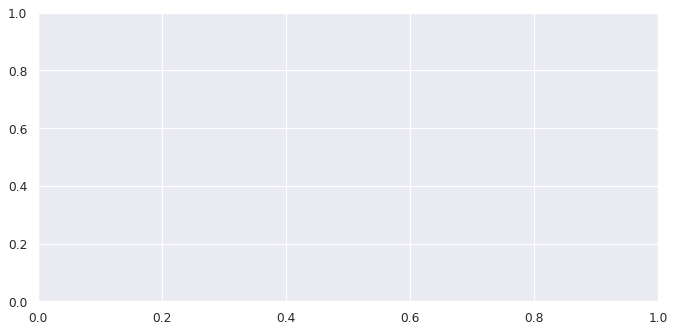

In [315]:
#Plot difference between actual (KFAST) and commanded (STI) rotspeed

#NOTE: >>>> cmd_rot_speed_c is at double the rate as rot_speed_c, so need to decimate  <<<<
#decimate to the frequency of csim
cmd_decimation=int(round(len(cmd_rot_speed_c[:,0])/len(rot_speed_c[:,0])))
print('cmd_decimation ={:5.3f}'.format(cmd_decimation))

fig= plt.figure(figsize=(22, 22), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_k[idx_k],rot_speed_k[:,irot]-rot_speed_STI[::2,irot],label=rotspeedstr[irot]+'_k',color='red')
    factor=(irot==0) | (irot==3) | (irot==5) | (irot==6)
    if factor:
        factor=-1
    else:
        factor=1
    ax[irot].plot(time_c2k,rot_speed_c[:,irot]-factor*cmd_rot_speed_c[::cmd_decimation,irot],label=rotspeedstr[irot]+'_c',color='blue',linestyle='--')

    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('rotspeed [rad/s]')
    ax[irot].set_title('KFAST rotspeed - STI Commanded, and CSIM actual - commanded')
    plt.legend(loc='best')

plt.show()

In [316]:
time_c2k[0:50].transpose(), rot_speed_c[0:50,0]

(array([[0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
         0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
         0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
         0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
         0.88, 0.9 , 0.92, 0.94, 0.96, 0.98]]),
 array([-147.04030494, -146.86937087, -146.7097513 , -146.55541541,
        -146.42951565, -146.27090628, -146.09043765, -145.89317152,
        -145.71401392, -145.54854875, -145.39633765, -145.23445391,
        -145.07707168, -144.97606895, -144.88508385, -144.76173695,
        -144.63653561, -144.49345159, -144.34960164, -144.22821073,
        -144.09736821, -143.97081492, -143.8106306 , -143.60426467,
        -143.41555458, -143.24349134, -143.09092289, -142.92981078,
        -142.77124583, -142.59807395, -142.41564609, -142.21116888,
        -142.00791783, -141.85009763, -141.69608122, -141.54832364,
        -141.39393241, -141.23485073, -1

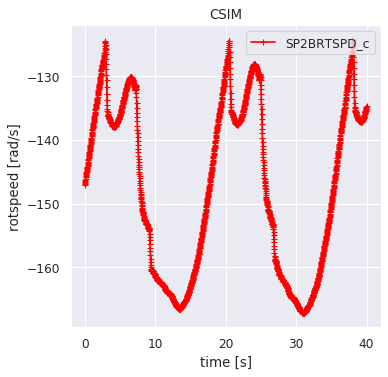

In [317]:
fig= plt.figure(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(1, 1, 1)
ax.plot(time_c2k,rot_speed_c[:,0],label=rotspeedstr[0]+'_c',color='red',marker='+')
ax.set_xlabel('time [s]')
ax.set_ylabel('rotspeed [rad/s]')
ax.set_title('CSIM')
plt.legend(loc='best')

plt.show()

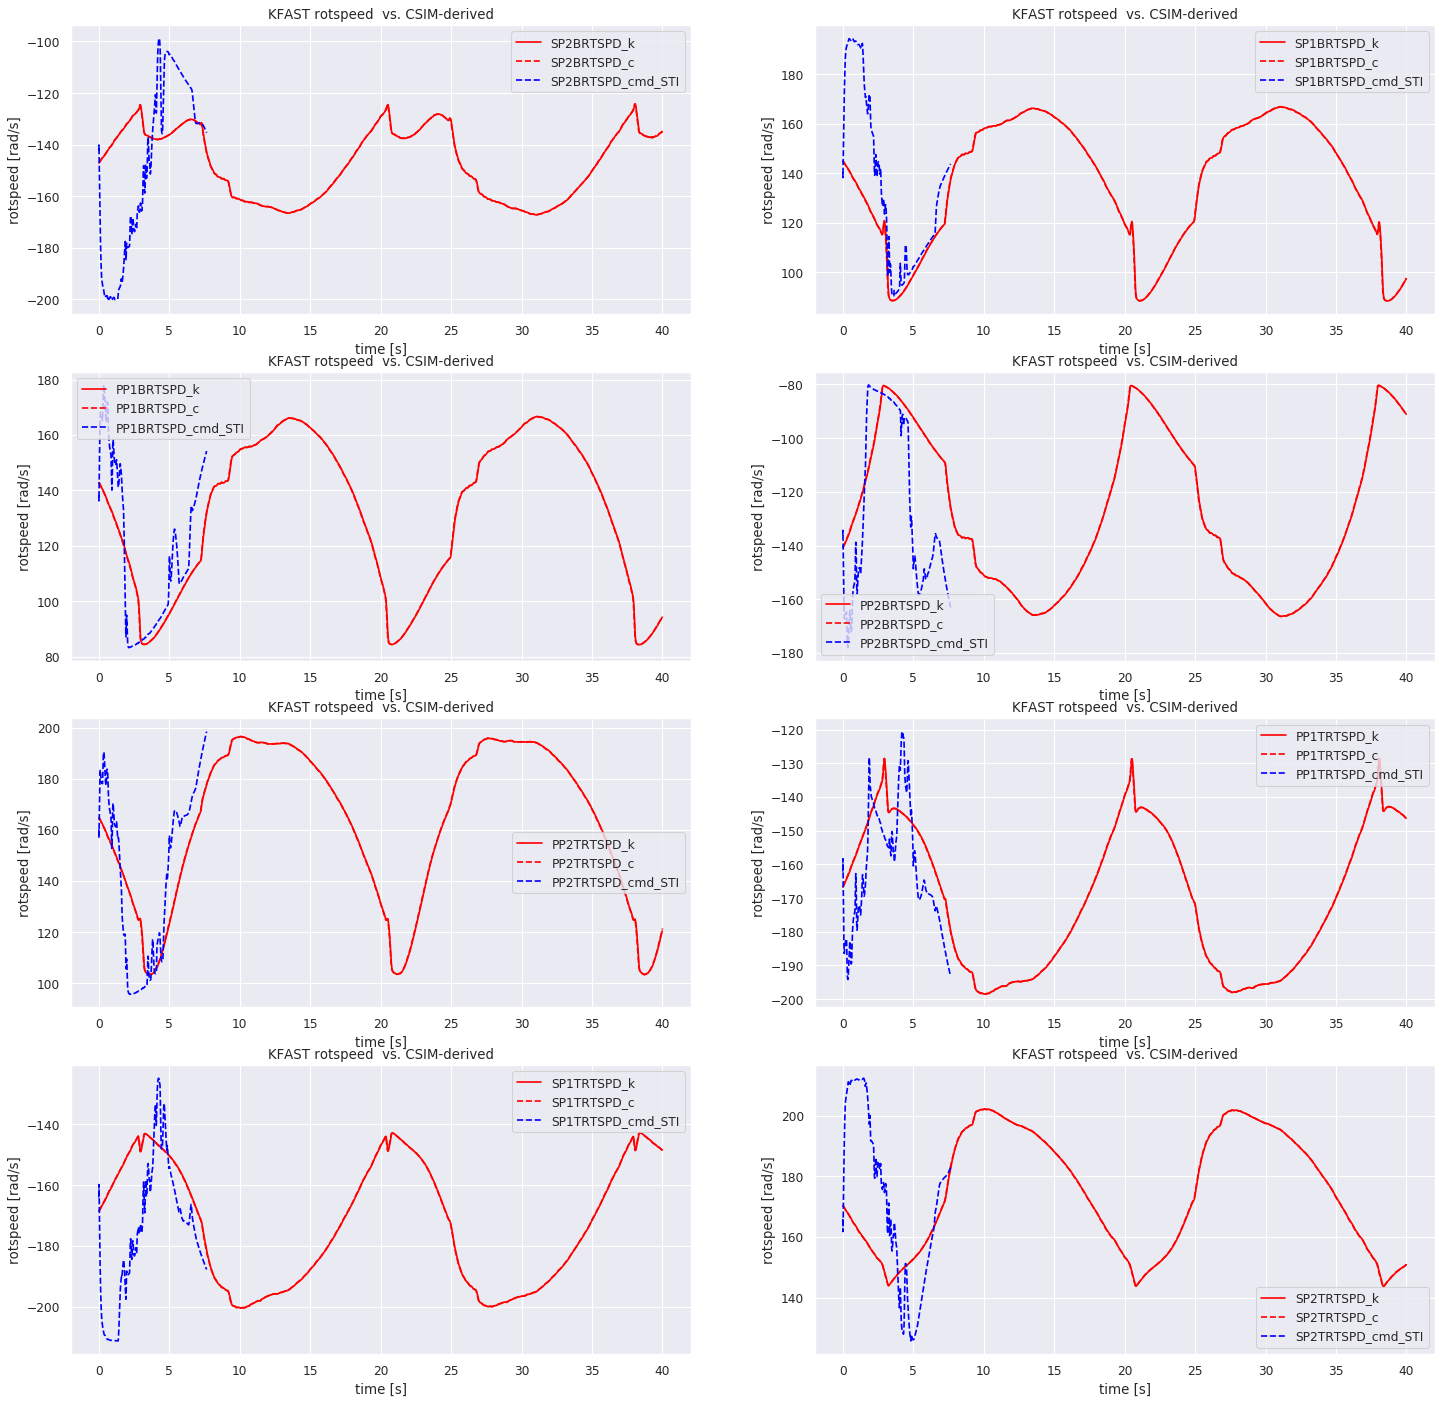

In [318]:
#Plot Rotor Speeds: CSIM derived and commanded  vs.  KFAST Received and also STI commanded

if injupyter:
    %matplotlib inline 
#notebook

                
                   
ax=[None]*nmotors

fig= plt.figure(figsize=(22, 22), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_k[idx_k],rot_speed_k[:,irot],label=rotspeedstr[irot]+'_k',color='red')
    ax[irot].plot(time_c2k,rot_speed_c[:,irot],label=rotspeedstr[irot]+'_c',color='red',linestyle='--')
    ax[irot].plot(time_STI,rot_speed_STI[:,irot],label=rotspeedstr[irot]+'_cmd_STI',color='blue',linestyle='--')
    #ax[irot].plot(time_c2k,cmd_rot_speed_c[::cmd_decimation,irot],label=rotspeedstr[irot]+'_cmd_c',color='blue',linestyle='--')
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('rotspeed [rad/s]')
    ax[irot].set_title('KFAST rotspeed  vs. CSIM-derived')
    plt.legend(loc='best')

plt.show()

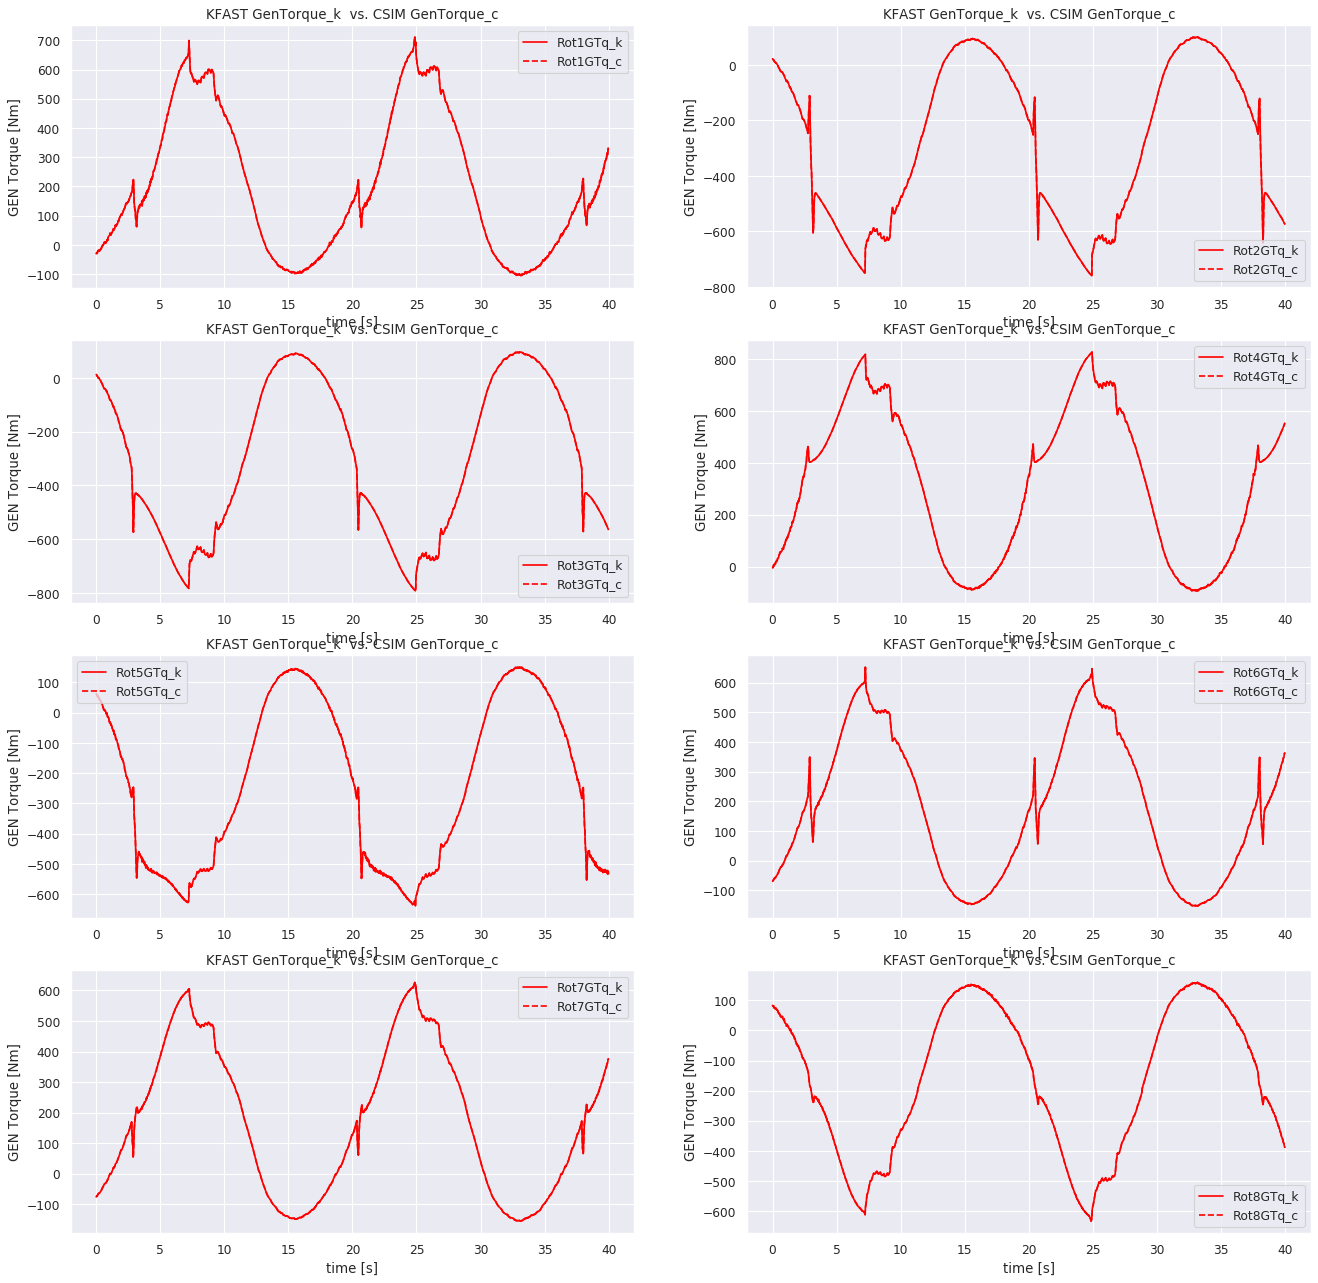

In [319]:
#Plot GenTorques: 1st CSIM derived  vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_kfc,gen_torque_k[:,irot],label=genTorquestr[irot]+'_k',color='red')
    ax[irot].plot(time_c2k,gen_torque_c[:,irot],label=genTorquestr[irot]+'_c',color='red',linestyle='--')
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('GEN Torque [Nm]')
    ax[irot].set_title('KFAST GenTorque_k  vs. CSIM GenTorque_c')
    plt.legend(loc='best')
    #ax[irot].set_ylim([-5,5])
plt.show()

## Let us check Aerotorques in more detail from skew and relative airvel

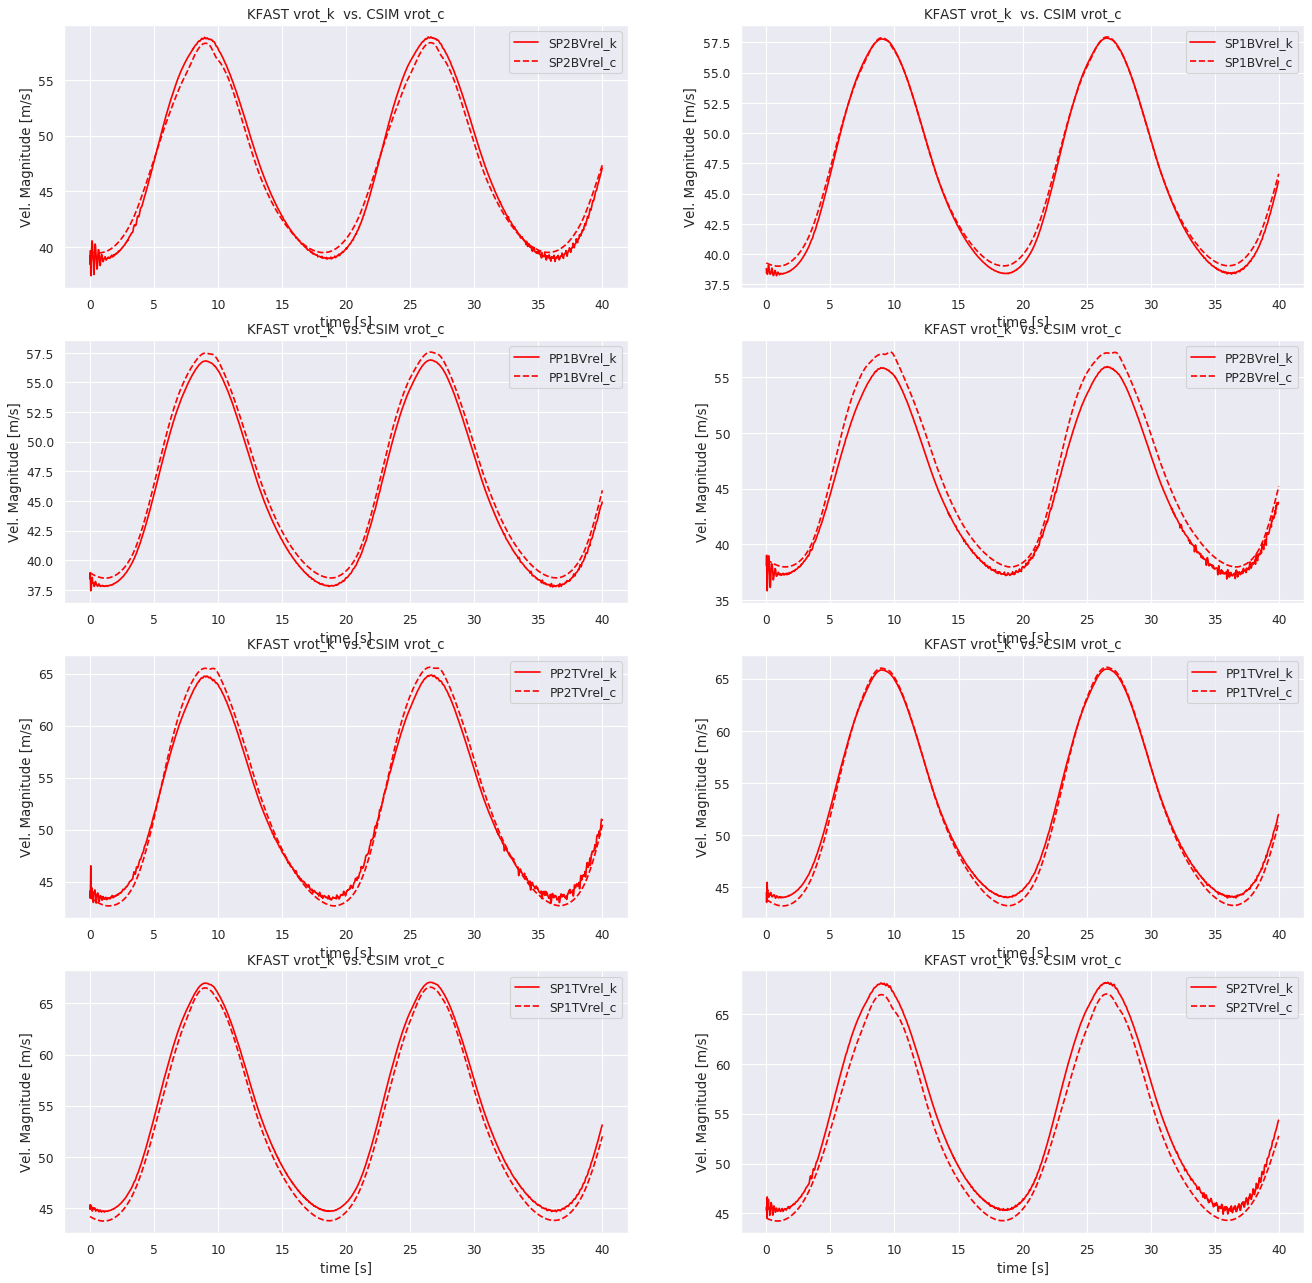

In [320]:
#Plot vrel at rotors and skew angles: 1st CSIM derived  vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_k[idx_k],vrot_k[:,irot],label=vrotstr[irot]+'_k',color='red')
    ax[irot].plot(time_c2k,vrot_c_mag[:,irot],label=vrotstr[irot]+'_c',color='red',linestyle='--')
    #ax[irot].plot(time_k[idx_k],vrot_k[:,irot]-vrot_c_mag[1:,irot],label=vrotstr[irot]+'_diff',color='red')
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('Vel. Magnitude [m/s]')
    ax[irot].set_title('KFAST vrot_k  vs. CSIM vrot_c')
    plt.legend(loc='best')
    #ax[irot].set_ylim([-5,5])
plt.show()

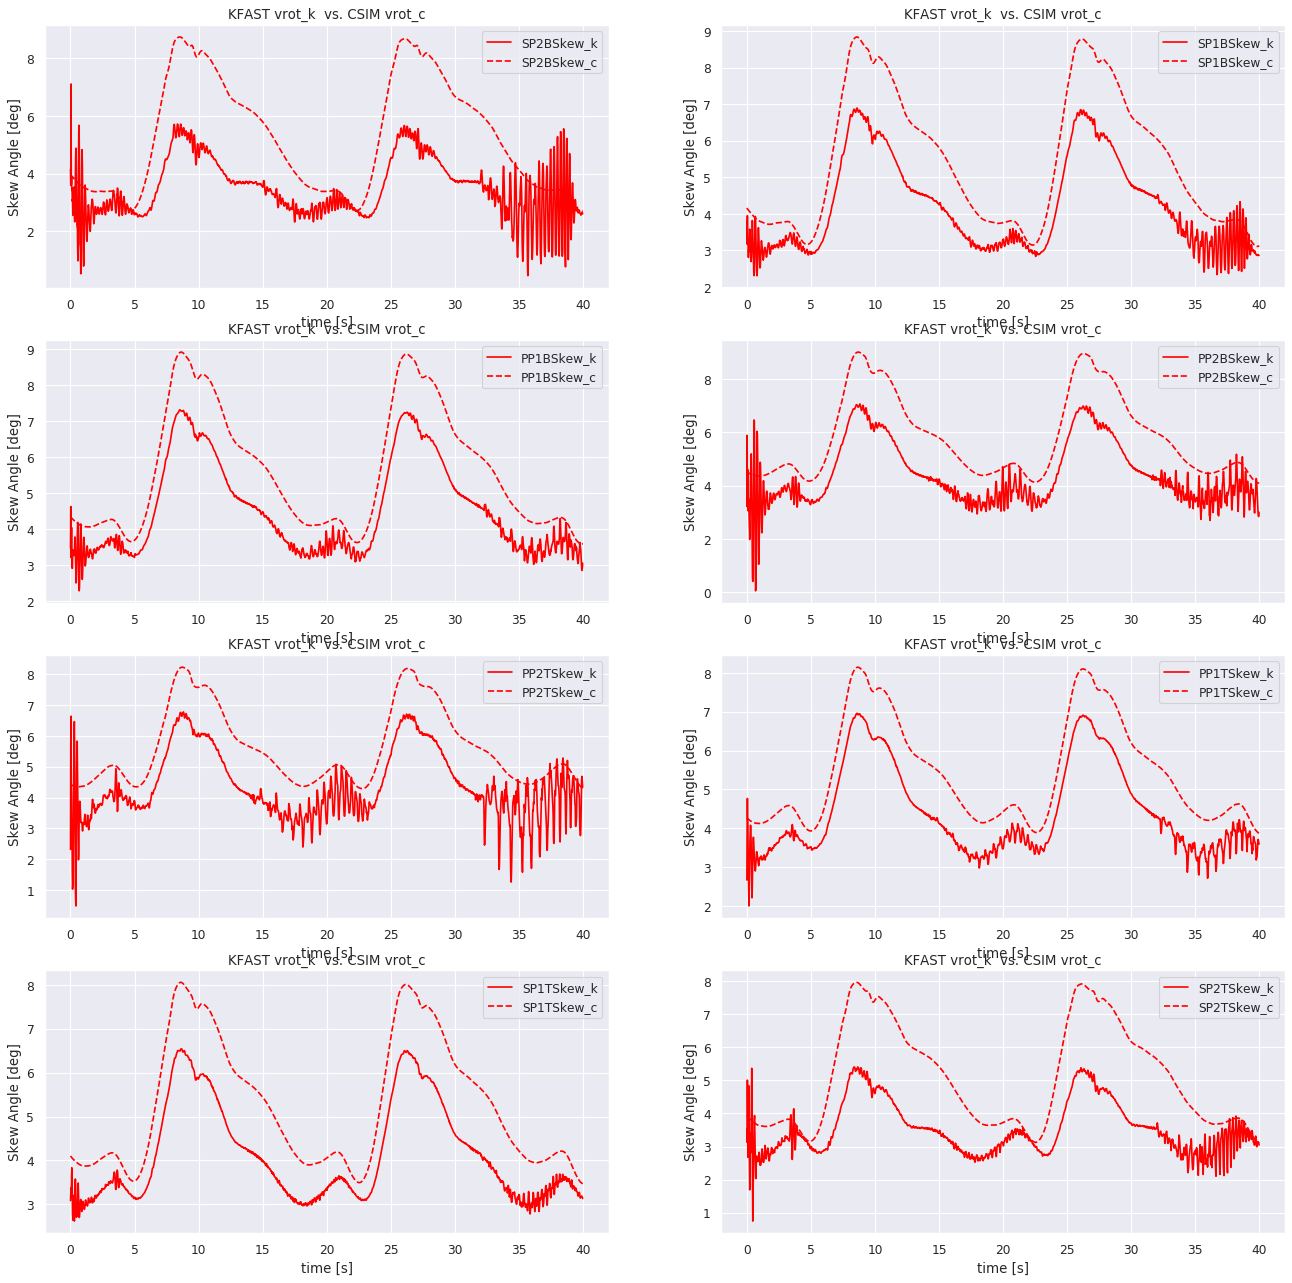

In [321]:
#Plot vrel at rotors and skew angles: 1st CSIM derived  vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_k[idx_k],chi_k[:,irot],label=skewstr[irot]+'_k',color='red')
    ax[irot].plot(time_c2k,np.rad2deg(chi_c[:,irot]),label=skewstr[irot]+'_c',color='red',linestyle='--')
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('Skew Angle [deg]')
    ax[irot].set_title('KFAST vrot_k  vs. CSIM vrot_c')
    plt.legend(loc='best')
    #ax[irot].set_ylim([-5,5])
plt.show()

I bet these differences are due to shaft tilt, not included in KFAST m600 model (yet)

### Thrust @ Rotors

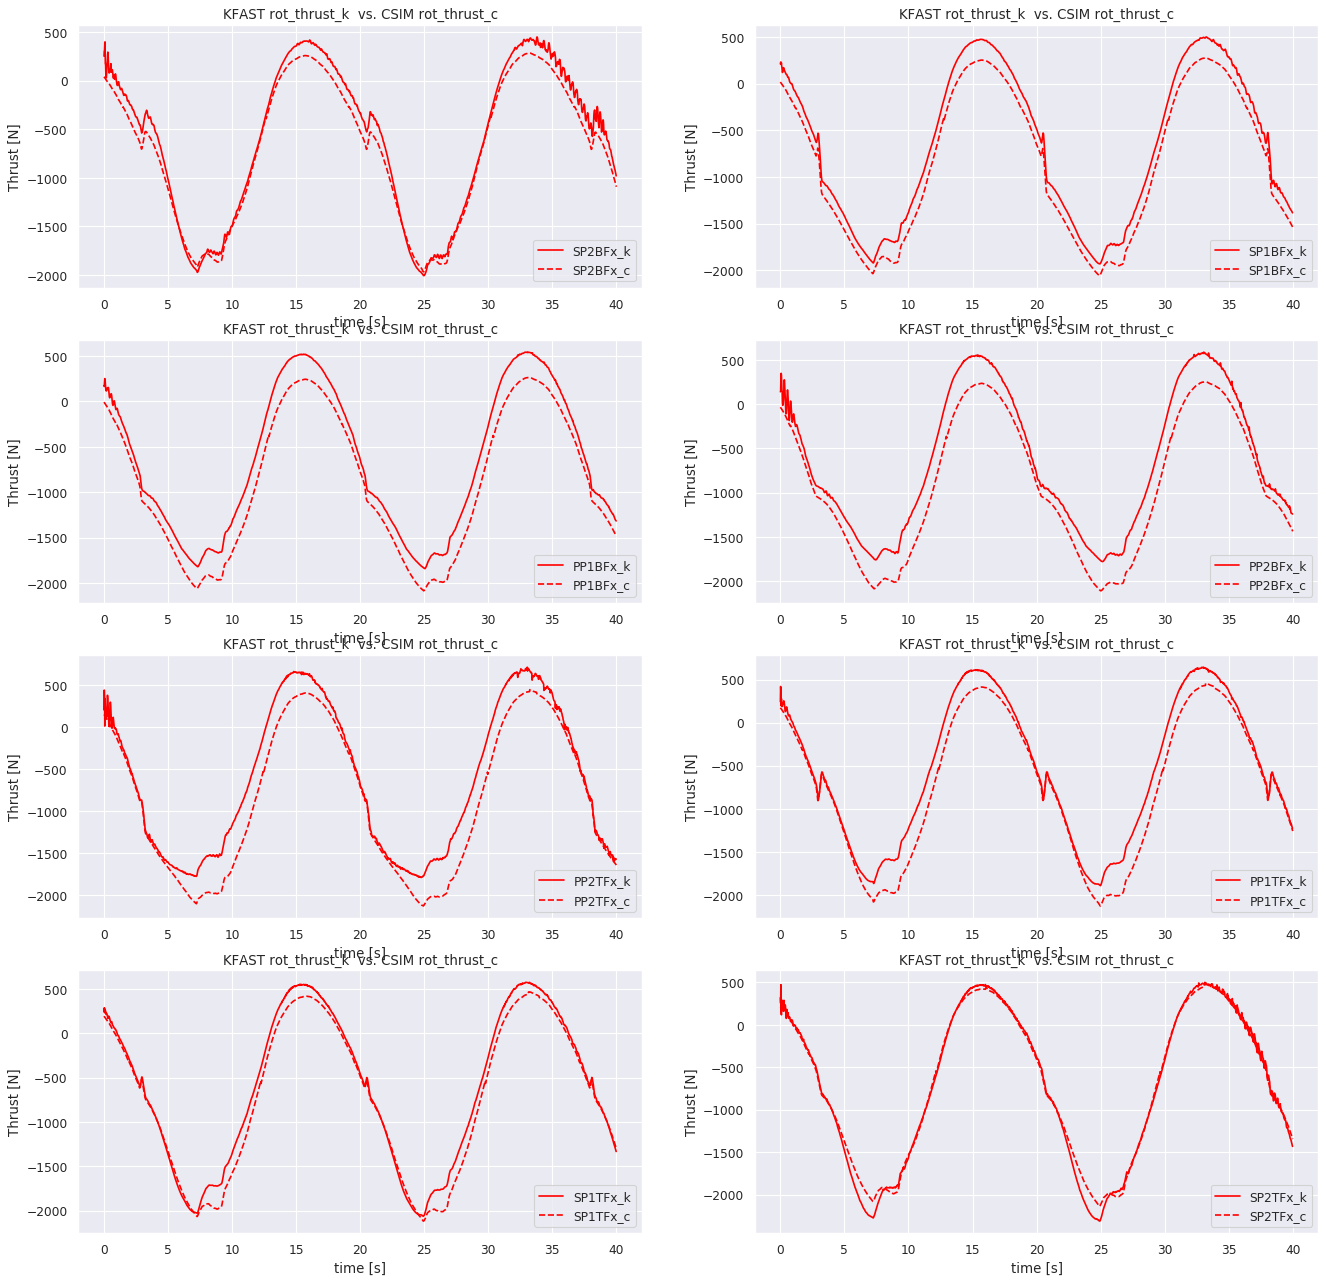

In [322]:
#Plot rotor thrusts in body (nacelle) ref frame: 1st CSIM derived  vs. 2nd KFAST Calculated
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*nmotors

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for irot in range(0,nmotors):
    ax[irot] = fig.add_subplot(4, 2, irot+1)
       
    ax[irot].plot(time_k[idx_k],rot_thrust_k[:,irot],label=Fxrotstr[irot]+'_k',color='red')
    ax[irot].plot(time_c2k,rot_thrust_c[:,irot],label=Fxrotstr[irot]+'_c',color='red',linestyle='--')
    ax[irot].set_xlabel('time [s]')
    ax[irot].set_ylabel('Thrust [N]')
    ax[irot].set_title('KFAST rot_thrust_k  vs. CSIM rot_thrust_c')
    plt.legend(loc='best')
    #ax[irot].set_ylim([-5,5])
plt.show()

# READ Control Surfaces Now

In [323]:
# KFAST surface deflections
# We will arrange in CSIM order !!!
#CSIM is flaps=[A1,A2,A4,A5,A7,A8,Ele,Rud] 
flap_str=['PFlp1Ctrl', 'PFlp2Ctrl', 'PFlp3Ctrl','SFlp1Ctrl', 'SFlp2Ctrl', 'SFlp3Ctrl','SElv1Ctrl', 'PElv1Ctrl', 'Rudr1Ctrl']
flapctrl_str=['Flp1Def', 'Flp2Def', 'Flp3Def','Flp4Def', 'Flp5Def','Flp6Def', 'Flp7Def', 'Flp8Def']

flap_df_k=df.loc[idx_k,flap_str].astype('float')
flap_df_k.describe()
flap_df_k.head(10)

PFlp1Ctrl  PFlp2Ctrl  PFlp3Ctrl  SFlp1Ctrl  SFlp2Ctrl  SFlp3Ctrl  \
1     -0.1374    -0.1381  -0.002359  -0.002359    -0.1531    -0.1525   
11    -0.1374    -0.1381  -0.002359  -0.002359    -0.1531    -0.1525   
21    -0.1372    -0.1378  -0.002356  -0.002356    -0.1534    -0.1528   
31    -0.1368    -0.1374  -0.002353  -0.002353    -0.1538    -0.1531   
41    -0.1364    -0.1371  -0.002351  -0.002351    -0.1542    -0.1535   
51    -0.1362    -0.1369  -0.002348  -0.002348    -0.1543    -0.1537   
61    -0.1363    -0.1369  -0.002345  -0.002345    -0.1543    -0.1536   
71    -0.1365    -0.1371  -0.002343  -0.002343    -0.1540    -0.1534   
81    -0.1364    -0.1371  -0.002340  -0.002340    -0.1541    -0.1534   
91    -0.1363    -0.1369  -0.002338  -0.002338    -0.1542    -0.1536   

    SElv1Ctrl  PElv1Ctrl  Rudr1Ctrl  
1     0.06417    0.06417    0.01467  
11    0.06417    0.06417    0.01467  
21    0.06428    0.06428    0.01507  
31    0.06451    0.06451    0.01542  
41    0.06461    0.06461    0.01587  
51    0.06460    0.06460    0.01648  
61    0.06465    0.06465    0.01699  
71    0.06476    0.06476    0.01735  
81    0.06485    0.06485    0.01764  
91    0.06495    0.06495    0.01803

In [324]:
flaps_k=flap_df_k.to_numpy('float')
#
flaps_k.shape

(2000, 9)

In [325]:
# KFASTController flap deflections (before mapping that is): They need to come from KiteFAST.KFC.out
# It has its own time step so cannot use idx_k <<<<!<<<<<
flp_kfc_df_k=df_kfc.loc[1:,flapctrl_str].astype('float')
flp_kfc_df_k.describe()
flaps_kfc_k=flp_kfc_df_k.to_numpy('float')
#
flaps_kfc_k.shape

(2001, 8)

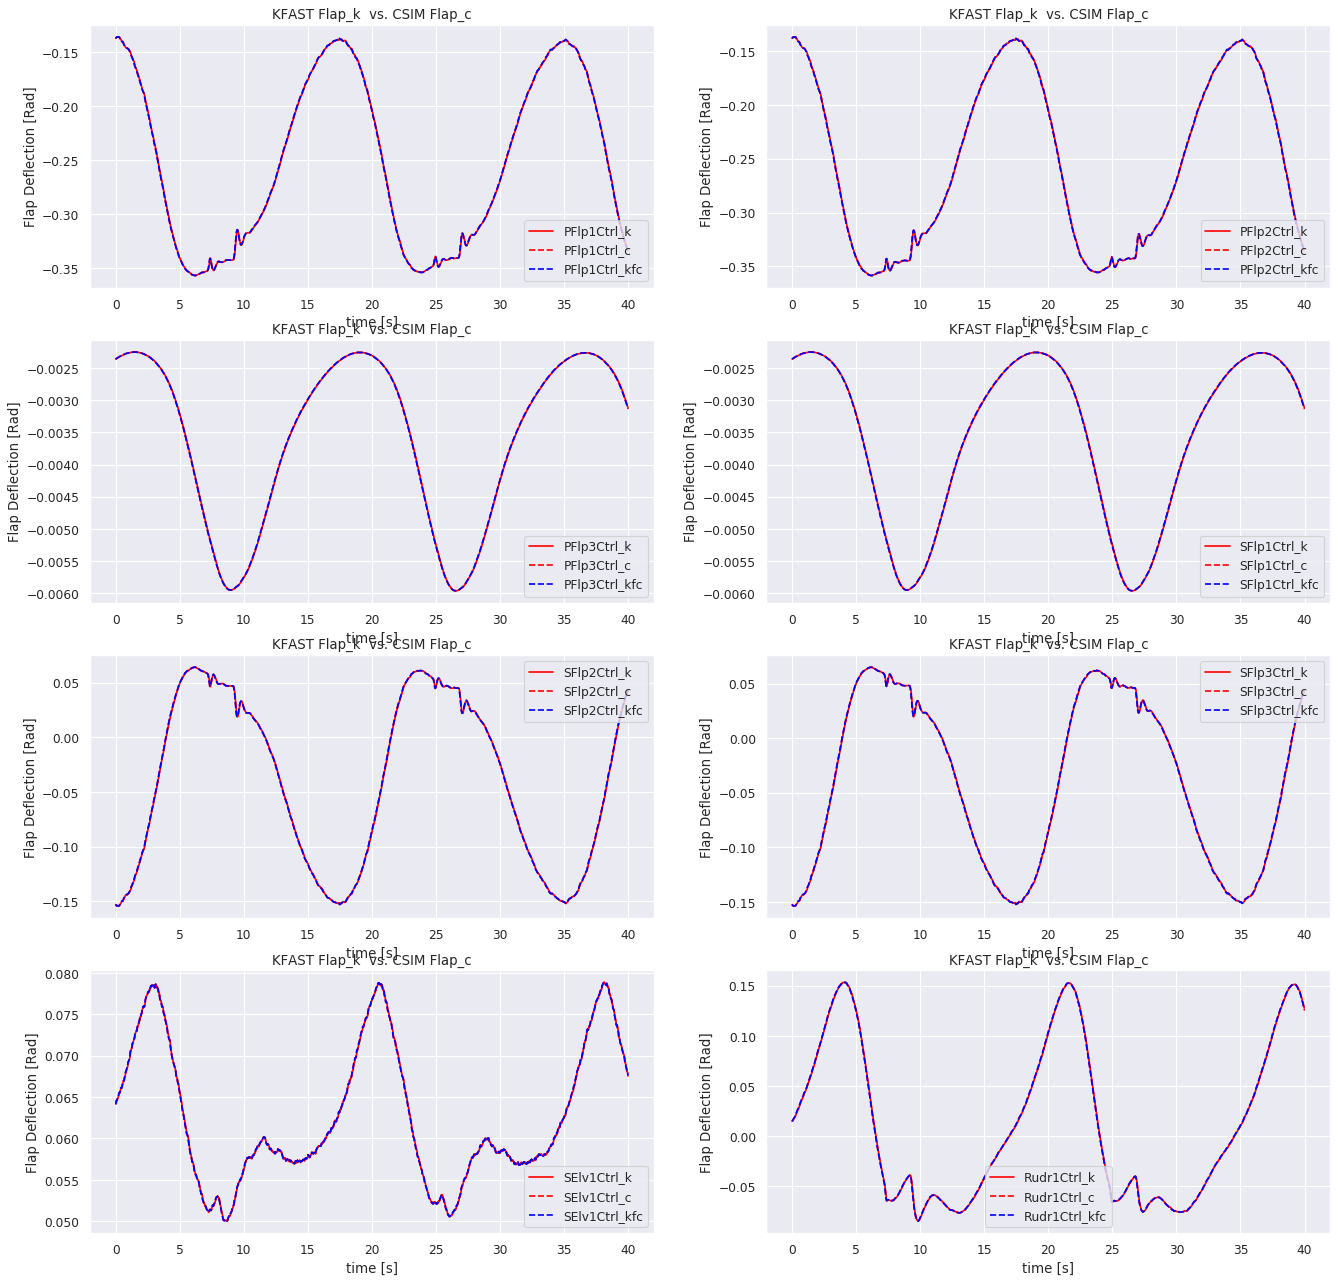

In [326]:
#Plot Flap Deflections: 1st CSIM derived  vs. 2nd KFAST received
if injupyter:
    %matplotlib inline
ax=[None]*nflaps

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for iflap in range(0,nflaps):
    ax[iflap] = fig.add_subplot(4, 2, iflap+1)
    iflapk=iflap  
    if iflap==7: #KFAST has 2 elevators instead of 1
        iflapk=iflap+1
        
    ax[iflap].plot(time_k[idx_k],flaps_k[:,iflapk],label=flap_str[iflapk]+'_k',color='red')
    ax[iflap].plot(time_c2k,flaps_c[:,iflap],label=flap_str[iflapk]+'_c',color='red',linestyle='--')
    ax[iflap].plot(time_kfc,flaps_kfc_k[:,iflap],label=flap_str[iflapk]+'_kfc',color='blue',linestyle='--')
    ax[iflap].set_xlabel('time [s]')
    ax[iflap].set_ylabel('Flap Deflection [Rad]')
    ax[iflap].set_title('KFAST Flap_k  vs. CSIM Flap_c')
    plt.legend(loc='best')
    #ax[irot].set_ylim([-5,5])
plt.show()

### Get the Initial Conditions to set into Ctrl_Input_File.dat :

In [327]:
print( ("Initial Flap Settings in rad "+nflaps*"{:7.6f} ").format(*flaps_c[100,:])  )
print( ("Initial Flap Settings in degree "+nflaps*"{:5.3f}").format(*np.rad2deg(flaps_c[0,:]))  )

Initial Flap Settings in rad -0.182296 -0.182972 -0.002268 -0.002268 -0.108093 -0.107465 0.075083 0.084201 
Initial Flap Settings in degree -7.875-7.912-0.135-0.135-8.774-8.7363.6770.841


In [328]:
print( ("Initial GenTorque Settings in Nm "+nmotors*"{:5.3f} ").format(*gen_torque_c[0,:])  )

Initial GenTorque Settings in Nm -30.173 21.697 12.640 -3.371 61.979 -68.994 -76.138 83.087 


In [329]:
print( ("Initial RtrSpd Settings in rad/s "+nmotors*"{:5.3f} ").format(*rot_speed_c[0,:])  )

Initial RtrSpd Settings in rad/s -147.040 144.957 142.848 -140.691 164.788 -166.670 -168.517 170.324 


In [330]:
print( ("Initial RtrAccel Settings in rad/s^2 "+nmotors*"{:5.3f} ").format(*rot_accel_c[0,:])  )

Initial RtrAccel Settings in rad/s^2 7.521 -8.332 -9.234 10.085 -9.473 8.807 8.287 -7.706 


In [331]:
## This is where we are: review against mistakes, then cehck Vb vs Vg, why noise in Vb_y, and then sideslip

# Total Aero Forces  

In [332]:
#From FAST we get the forces in inertial coordinates, so we need to manipulate them to get to body coordinate
#Additionally they contain rotor forces and moments which we should remove
KiteAeroF_str=np.core.defchararray.add(np.tile('AirfF',ncoords),np.core.defchararray.add(coords,np.tile('i',ncoords)))
KiteAeroM_str=np.core.defchararray.add(np.tile('AirfM',ncoords),np.core.defchararray.add(coords,np.tile('i',ncoords)))
KiteAeroFM_str=np.hstack([KiteAeroF_str,KiteAeroM_str])
KiteAeroF2_str=np.core.defchararray.add(np.tile('KiteF',ncoords),np.core.defchararray.add(coords,np.tile('i',ncoords)))
KiteAeroM2_str=np.core.defchararray.add(np.tile('KiteM',ncoords),np.core.defchararray.add(coords,np.tile('i',ncoords)))
Faero_df_k=df.loc[idx_k,KiteAeroF_str].astype('float')
Faero2_df_k=df.loc[idx_k,KiteAeroF2_str].astype('float')
Maero_df_k=df.loc[idx_k,KiteAeroM_str].astype('float')
Maero2_df_k=df.loc[idx_k,KiteAeroM2_str].astype('float')
Faero_df_k.describe()
Faero_df_k.head(10),KiteAeroFM_str,dcm_g2b_c2k.shape

(    AirfFxi  AirfFyi  AirfFzi
 1   43000.0  -7923.0  46590.0
 11  43490.0  -8678.0  49170.0
 21  45680.0  -9918.0  50580.0
 31  45090.0  -9711.0  49360.0
 41  43190.0  -8479.0  46100.0
 51  40950.0  -7517.0  43580.0
 61  40740.0  -7292.0  43020.0
 71  42740.0  -7691.0  45550.0
 81  44610.0  -8421.0  48290.0
 91  45660.0  -8874.0  49750.0,
 array(['AirfFxi', 'AirfFyi', 'AirfFzi', 'AirfMxi', 'AirfMyi', 'AirfMzi'],
       dtype='<U7'),
 (2001, 3, 3))

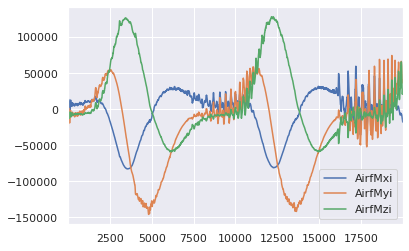

In [333]:
Maero_df_k.plot()

In [334]:
#Now put kitefast forces and moments into body coordinates DCM_G2B * F , DCM_G2B*M 
Faero_k=np.einsum('kij,kj->ki', mipdcm_k, Faero_df_k.to_numpy())  #this is the way i managed to get matmul to work with 3d x 2d arrays
Faero2_k=np.einsum('kij,kj->ki', mipdcm_k, Faero2_df_k.to_numpy())  #this is the way i managed to get matmul to work with 3d x 2d arrays
Maero_k=np.einsum('kij,kj->ki', mipdcm_k, Maero_df_k.to_numpy())  #this is the way i managed to get matmul to work with 3d x 2d arrays
Maero2_k=np.einsum('kij,kj->ki', mipdcm_k, Maero2_df_k.to_numpy())  #this is the way i managed to get matmul to work with 3d x 2d arrays
#since j disappears, it is summed upon

FM_aero_k=np.hstack([Faero_k, Maero_k])

FM_aero_k.shape,Faero_k.shape, dcm_fromatt_k.shape, Faero_df_k.to_numpy().shape

((2000, 6), (2000, 3), (2000, 3, 3), (2000, 3))

### Let us correct the CSIM moments to be placed at (0,0,0) since they are applied at the CG

In [335]:
#The CG:
log['parameters']['system_params']['ground_frame']
CGb_c=log['parameters']['system_params']['wing']['center_of_mass_pos'][0]
CGb_c=np.hstack(CGb_c)
print(CGb_c)
mipi_mbdyn=np.array([421.6446001278,22.4402833375,109.4935746309])
mipi_mbdyn=init_Xg_k
#CGi_mbdyn=np.array([421.497,22.5604,109.504]) #low start
CGi_mbdyn=np.array([299.532, 17.4232, 313.71])
CGi_k=CGi_mbdyn-mipi_mbdyn
CGb_k=np.matmul(mipdcm_k[0,:,:],CGi_k)

print(('CGb_k='+3*'{:10.3f}').format(*CGb_k))
print(('CGb_c='+3*'{:10.3f}').format(*CGb_c))



[-0.085  0.037  0.108]
CGb_k=     0.148    -0.023     0.119
CGb_c=    -0.085     0.037     0.108


In [336]:
FM_aero_c2k=FM_aero_c[:,3:] + np.cross(CGb_c,FM_aero_c[:,:3]) #These are at the origin
FM_aero_c2k.shape

(2001, 3)

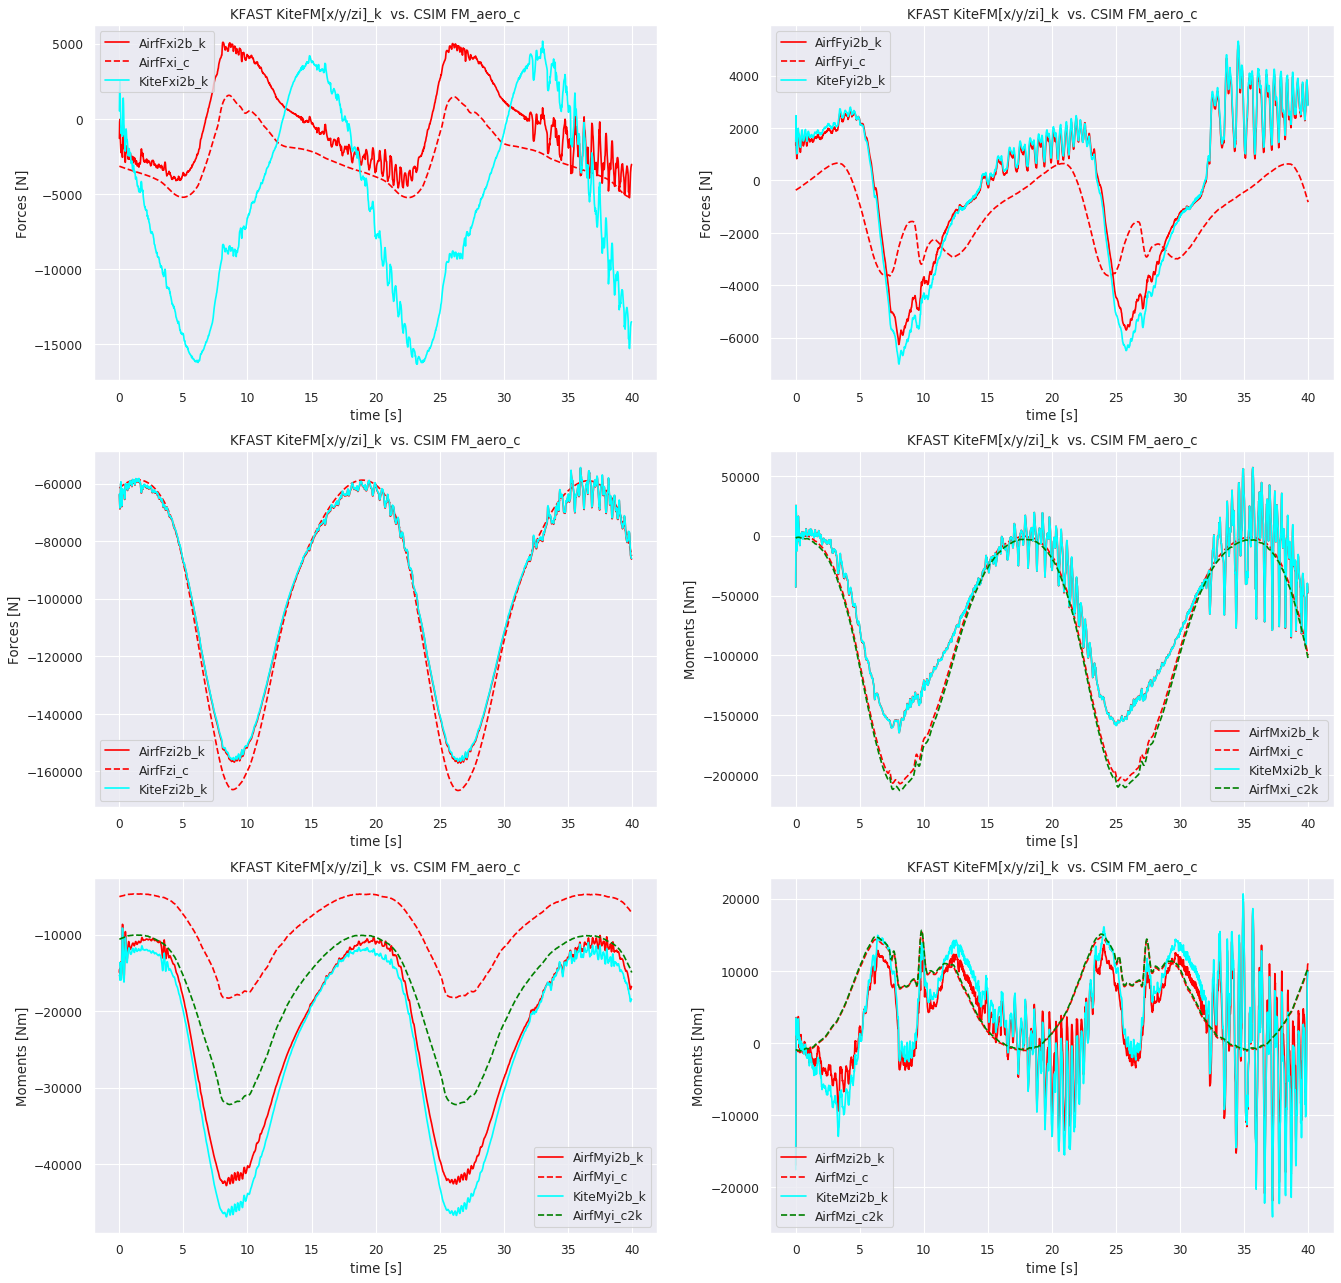

In [337]:
#Plot Aero forces
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*ncoords*2

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for icoord in range(0,2*ncoords):
    ax[icoord] = fig.add_subplot(3, 2, icoord+1)
        
    ax[icoord].plot(time_k[idx_k],FM_aero_k[:,icoord],label=KiteAeroFM_str[icoord]+'2b_k',color='red')
    ax[icoord].plot(time_c2k,FM_aero_c[:,icoord],label=KiteAeroFM_str[icoord]+'_c',color='red',linestyle='--')
    
    if (icoord < 3):
        ax[icoord].plot(time_k[idx_k],Faero2_k[:,icoord],label=KiteAeroF2_str[icoord]+'2b_k',color='cyan')
    else:
        ax[icoord].plot(time_k[idx_k],Maero2_k[:,icoord-3],label=KiteAeroM2_str[icoord-3]+'2b_k',color='cyan')
        ax[icoord].plot(time_c2k,FM_aero_c2k[:,icoord-3],label=KiteAeroFM_str[icoord]+'_c2k',color='green',linestyle='--')
    
    ax[icoord].set_xlabel('time [s]')
    ax[icoord].set_ylabel('Forces [N]')
    if (icoord >2):
        ax[icoord].set_ylabel('Moments [Nm]')
    ax[icoord].set_title('KFAST KiteFM[x/y/zi]_k  vs. CSIM FM_aero_c')
    plt.legend(loc='best')
    #ax[irot].set_ylim([-5,5])
plt.show()

Why does my KiteFx match CSIM fm_aero_x and not AifFx? This plot shows that the lift component along x is large and propels the kite, and the thrusts are negative as seen above; yet CSIM, even though has negative thrusts, shows less propulsion force from lift. Is it just by chance that the KiteFx overlaps so well with CSIM fm_aero? can we run CSIM with motors off?

What's happening on the lateral plane is  all messed up, and that might have to do with the sideslip story, which goes back to the Vb_y story. It is worth reanalyzing what is going on there, because the sideslip is measured at the pitot, and not at the 0,0,0 point, and we need to assess better whether omg_z is affecting it as well.

# Tether Anchor Force

In [338]:
#KFAST only returns this: (another missing key output that I augmented KFC for)
tether_force_k=df.loc[1:,'ANCHTEN1'].to_numpy('float') #in N,

#KFC output
teth_kfc_str=["TethFxb", "TethFyb", "TethFzb"]
teth_kfc=df_kfc.loc[1:,teth_kfc_str].astype('float').to_numpy()

#STI output
teth_sti_str=np.core.defchararray.add(np.tile('teth_vec_b.',ncoords),coords)
teth_sti_f=df_STI.loc[:,teth_sti_str].to_numpy()
teth_sti_f.shape


teth_kfc.shape,teth_kfc[100 ,:]


((2001, 3), array([ 8175., -3273., 62570.]))

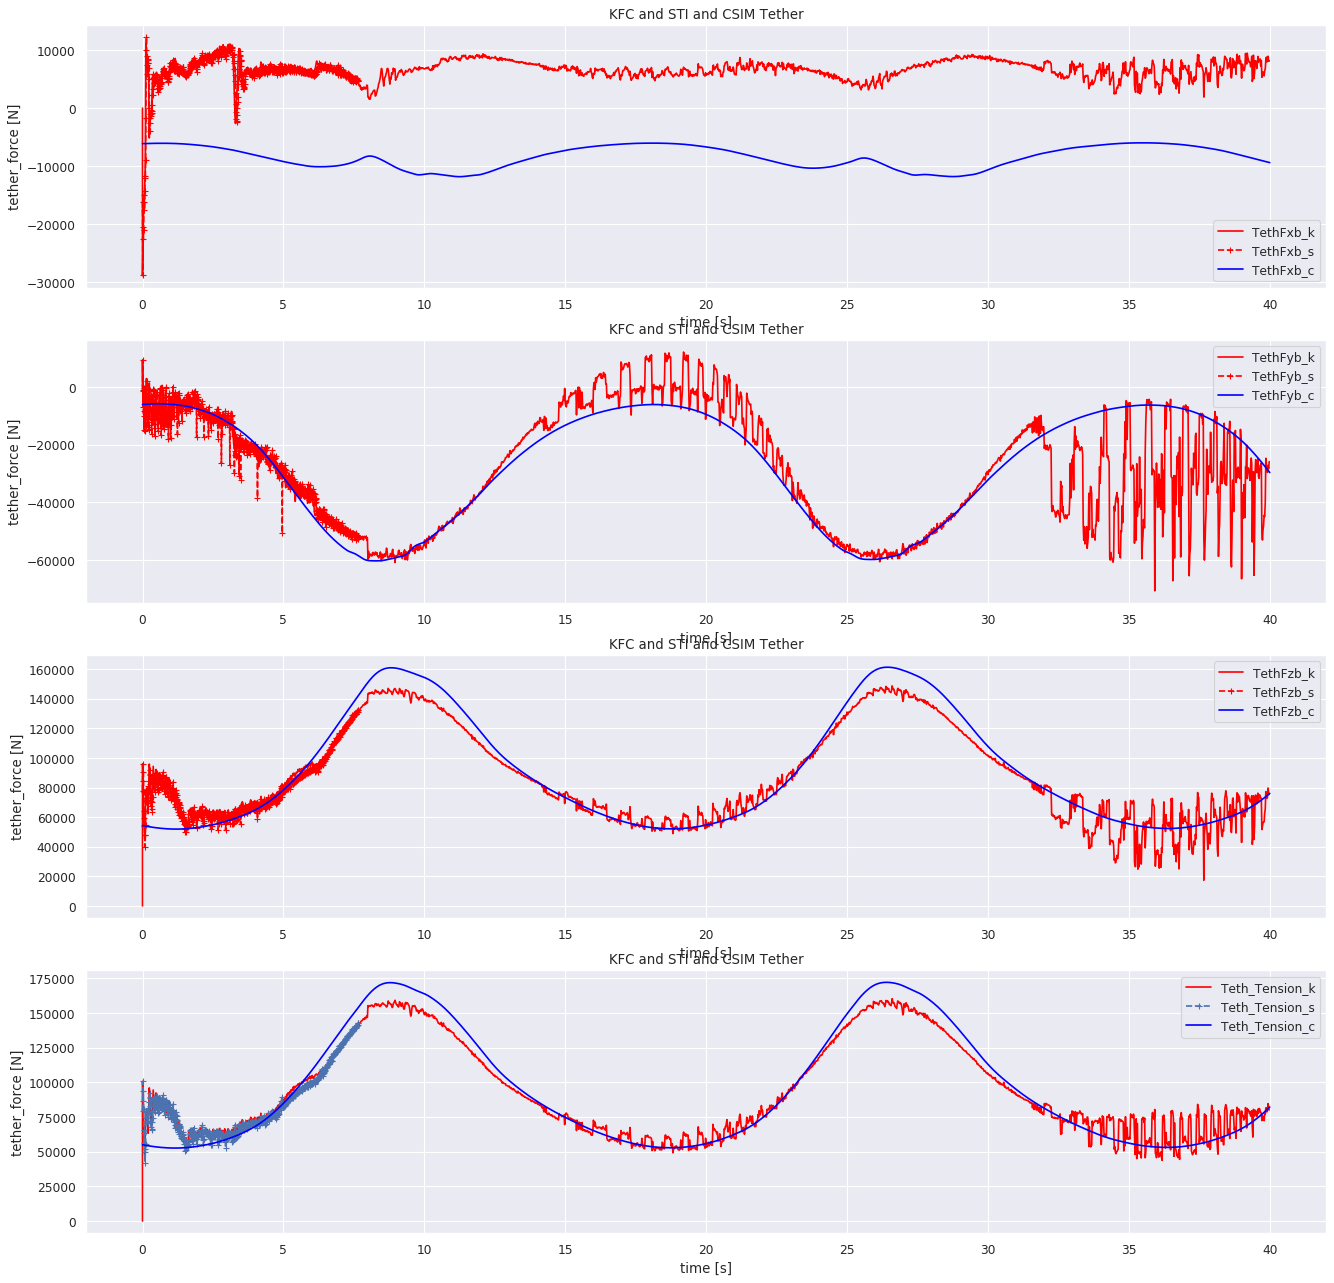

In [339]:
#Plot Tether 
if injupyter:
    %matplotlib inline 
#notebook

ax=[None]*4

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,4):
    ax[ii] = fig.add_subplot(4, 1, ii+1)

    if ii<3:
        ax[ii].plot(time_kfc,teth_kfc[:,ii],label=teth_kfc_str[ii]+'_k',color='red')
    
        ax[ii].plot(time_STI,teth_sti_f[:,ii],label=teth_kfc_str[ii]+'_s',color='red',linestyle='--',marker='+')
        ax[ii].plot(time_c2k,tether_vec_c[:,ii],label=teth_kfc_str[ii]+'_c',color='blue')
        
    else:
        ax[ii].plot(time_kfc,np.linalg.norm(teth_kfc,axis=1),label='Teth_Tension'+'_k',color='red')
        ax[ii].plot(time_STI,np.linalg.norm(teth_sti_f,axis=1),label='Teth_Tension'+'_s',linestyle='--',marker='+')
        ax[ii].plot(time_c2k,tether_force_b_c,label='Teth_Tension'+'_c',color='blue')

    ax[ii].set_xlabel('time [s]')
    ax[ii].set_ylabel('tether_force [N]')
    ax[ii].set_title('KFC and STI and CSIM Tether')

    
    plt.legend(loc='best')
plt.show()



In [340]:
tether_force_b_c.mean()/np.linalg.norm(teth_kfc,axis=1).mean() 


1.0117953399639696

### Now read in the CSV from the STI controller

(2001, 1) (2001,)


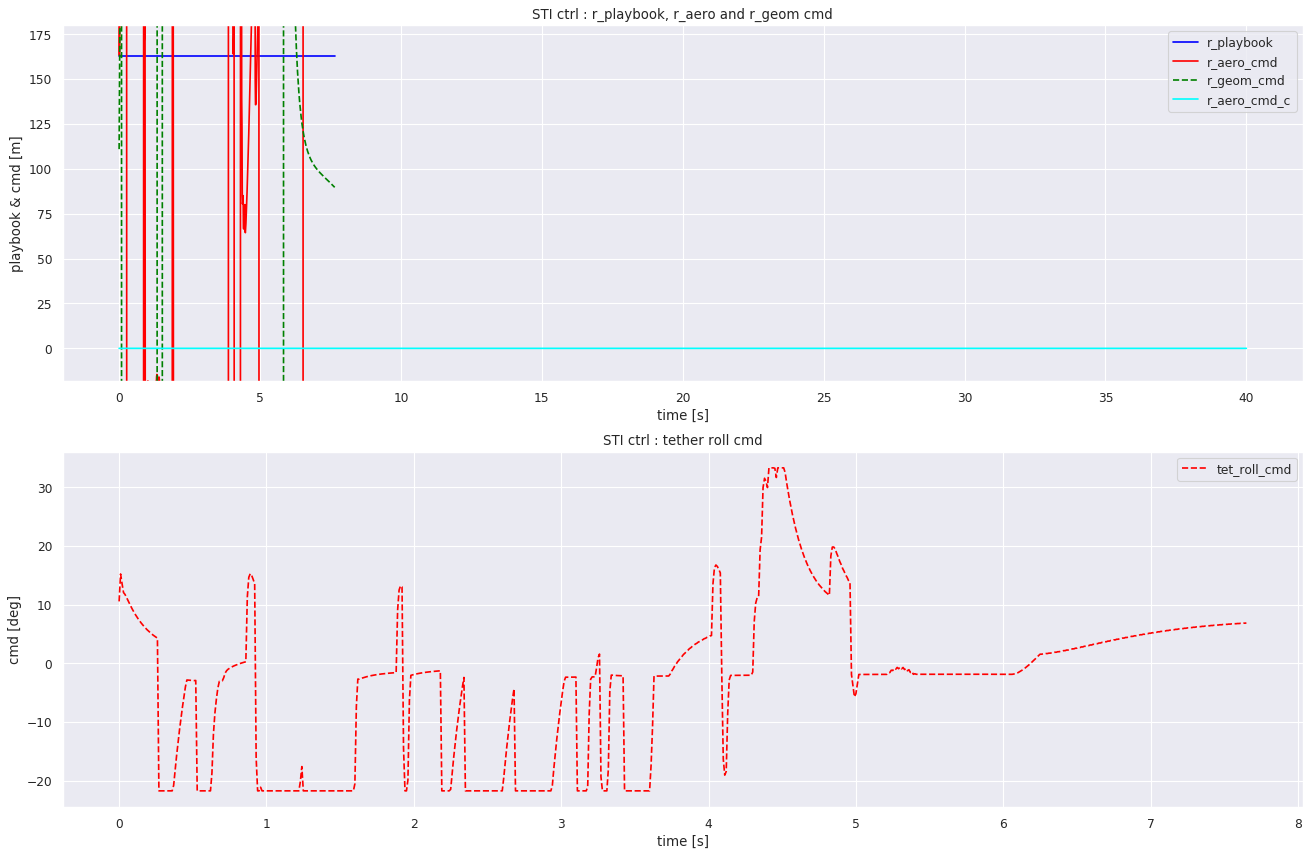

In [341]:
time_STI =df_STI['time'].to_numpy()
r_playbook=df_STI['path_rad_play_out'].to_numpy()
r_aero_cmd=-1./df_STI['k_aero_cmd_pth_out'].to_numpy()
r_geom_cmd=-1./df_STI['k_geom_cmd_pth_out'].to_numpy()
tet_roll_cmd=df_STI['tet_roll_cmd_crv_out'].to_numpy()

#add CSIM version
#tel2.dtype
#tel2['crosswind']['k_aero_cmd'].dtype
r_aero_cmd_c=tel3['crosswind']['k_aero_cmd'][tel3_idx0:]
r_geom_cmd_c=tel3['crosswind']['k_geom_cmd'][tel3_idx0:]
print(time_c2k.shape,r_aero_cmd_c[::2].shape)

ax=[None]*2

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
for ii in range(0,2):
    ax[ii] = fig.add_subplot(3, 1, ii+1)
    if ii<1:
        ax[ii].plot(time_STI,r_playbook,label='r_playbook',color='blue')
        ax[ii].plot(time_STI,r_aero_cmd,label='r_aero_cmd',color='red')
        ax[ii].plot(time_STI,r_geom_cmd,label='r_geom_cmd',color='green',linestyle='--')
        ax[ii].plot(time_c2k,r_aero_cmd_c[::2],label='r_aero_cmd_c',color='cyan')
        ax[ii].set_title('STI ctrl : r_playbook, r_aero and r_geom cmd')
        ax[ii].set_ylabel('playbook & cmd [m]')
        ax[ii].set_ylim(-18,180)
    else:
        ax[ii].plot(time_STI,np.rad2deg(tet_roll_cmd),label='tet_roll_cmd',color='red',linestyle='--')
        ax[ii].set_title('STI ctrl : tether roll cmd')
        ax[ii].set_ylabel('cmd [deg]')
    ax[ii].set_xlabel('time [s]')
    
    plt.legend(loc='best')
    
plt.show()


In [342]:
#Filtered PQR_f:
STI_pqrf_str=np.core.defchararray.add(np.tile('pqr_f.',ncoords),coords)
STI_pqrf_f=df_STI.loc[:,STI_pqrf_str].to_numpy()
STI_pqrf_f.shape

(766, 3)

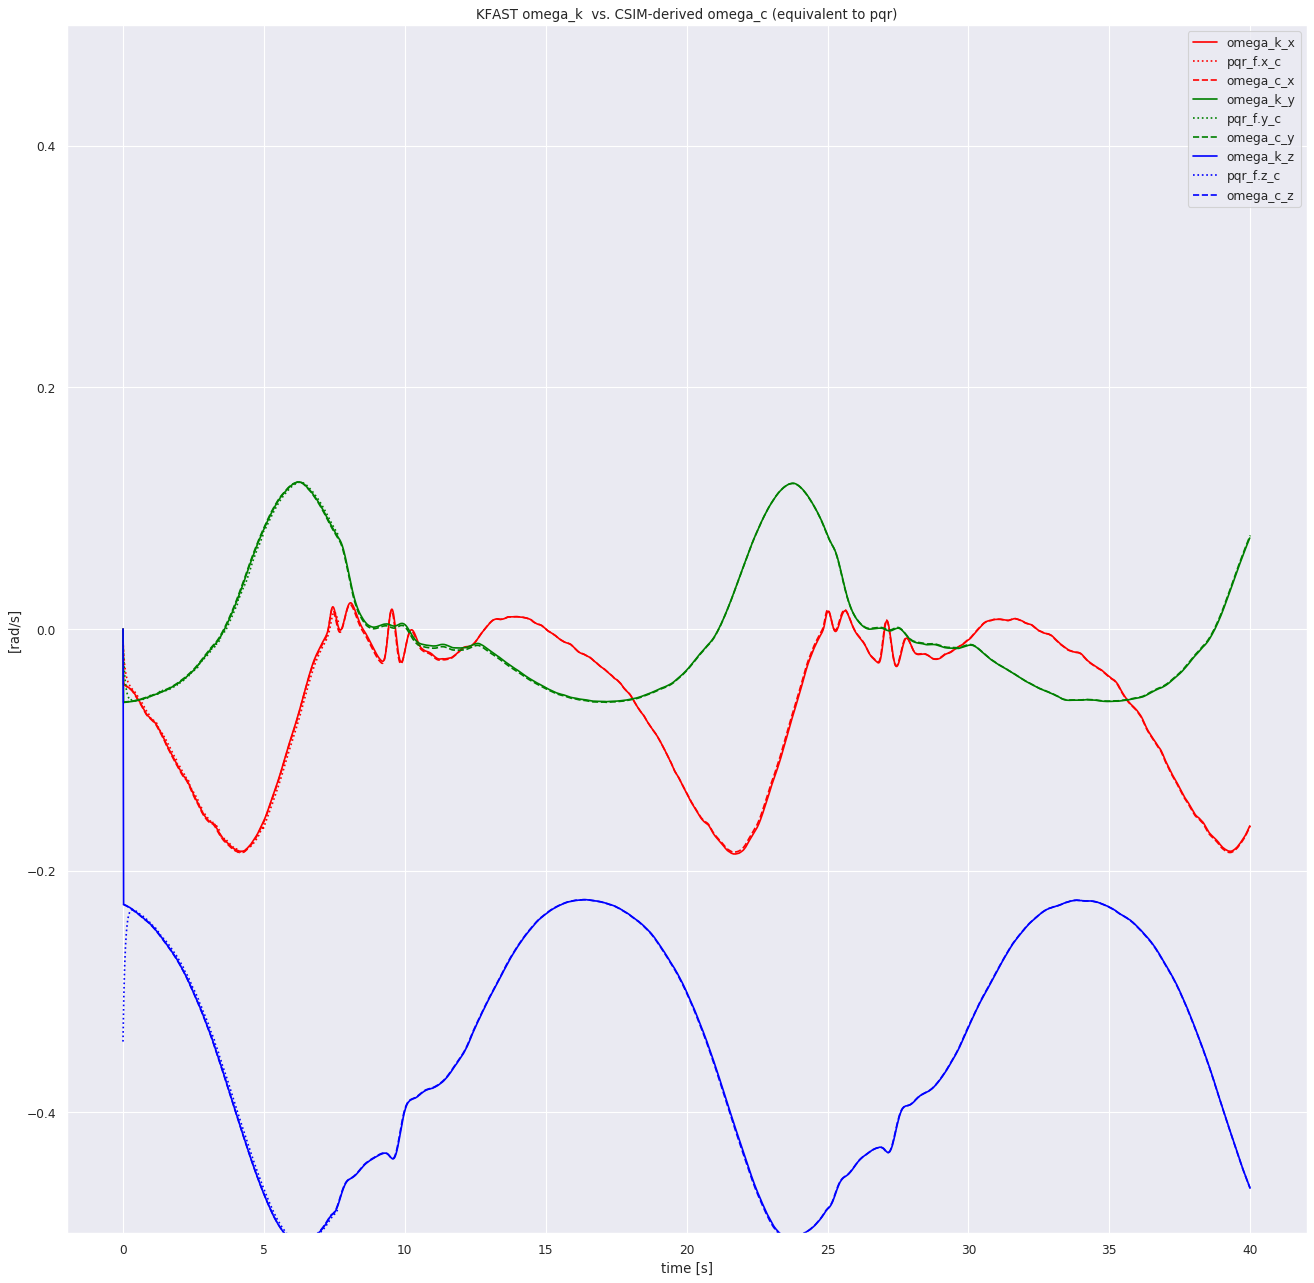

In [343]:
#Plot  filtered  pqr_f from STI
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*2

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
    
for ii in range(0,3):
    ax.plot(time_k[idx_k],omega_k[:,ii],label='omega_k_'+coords[ii],color=colors[ii])
    ax.plot(time_STI,STI_pqrf_f[:,ii],label=STI_pqrf_str[ii]+'_c',color=colors[ii],linestyle=':')
    ax.plot(time_c2k,omega_c[:,ii],label='omega_c_'+coords[ii],color=colors[ii],linestyle='--')

ax.set_xlabel('time [s]')
ax.set_ylabel('[rad/s]')
ax.set_ylim(-0.5,0.5)
ax.set_title('KFAST omega_k  vs. CSIM-derived omega_c (equivalent to pqr)')
plt.legend(loc='best')

In [344]:
#Filtered Ag_norm_f:
STI_Agnorm_f_str='acc_norm_f'
Ag_normf_STI=df_STI.loc[:,STI_Agnorm_f_str].to_numpy()
#Ag_normf_STI.describe()
Ag_normf_STI.shape

(766,)

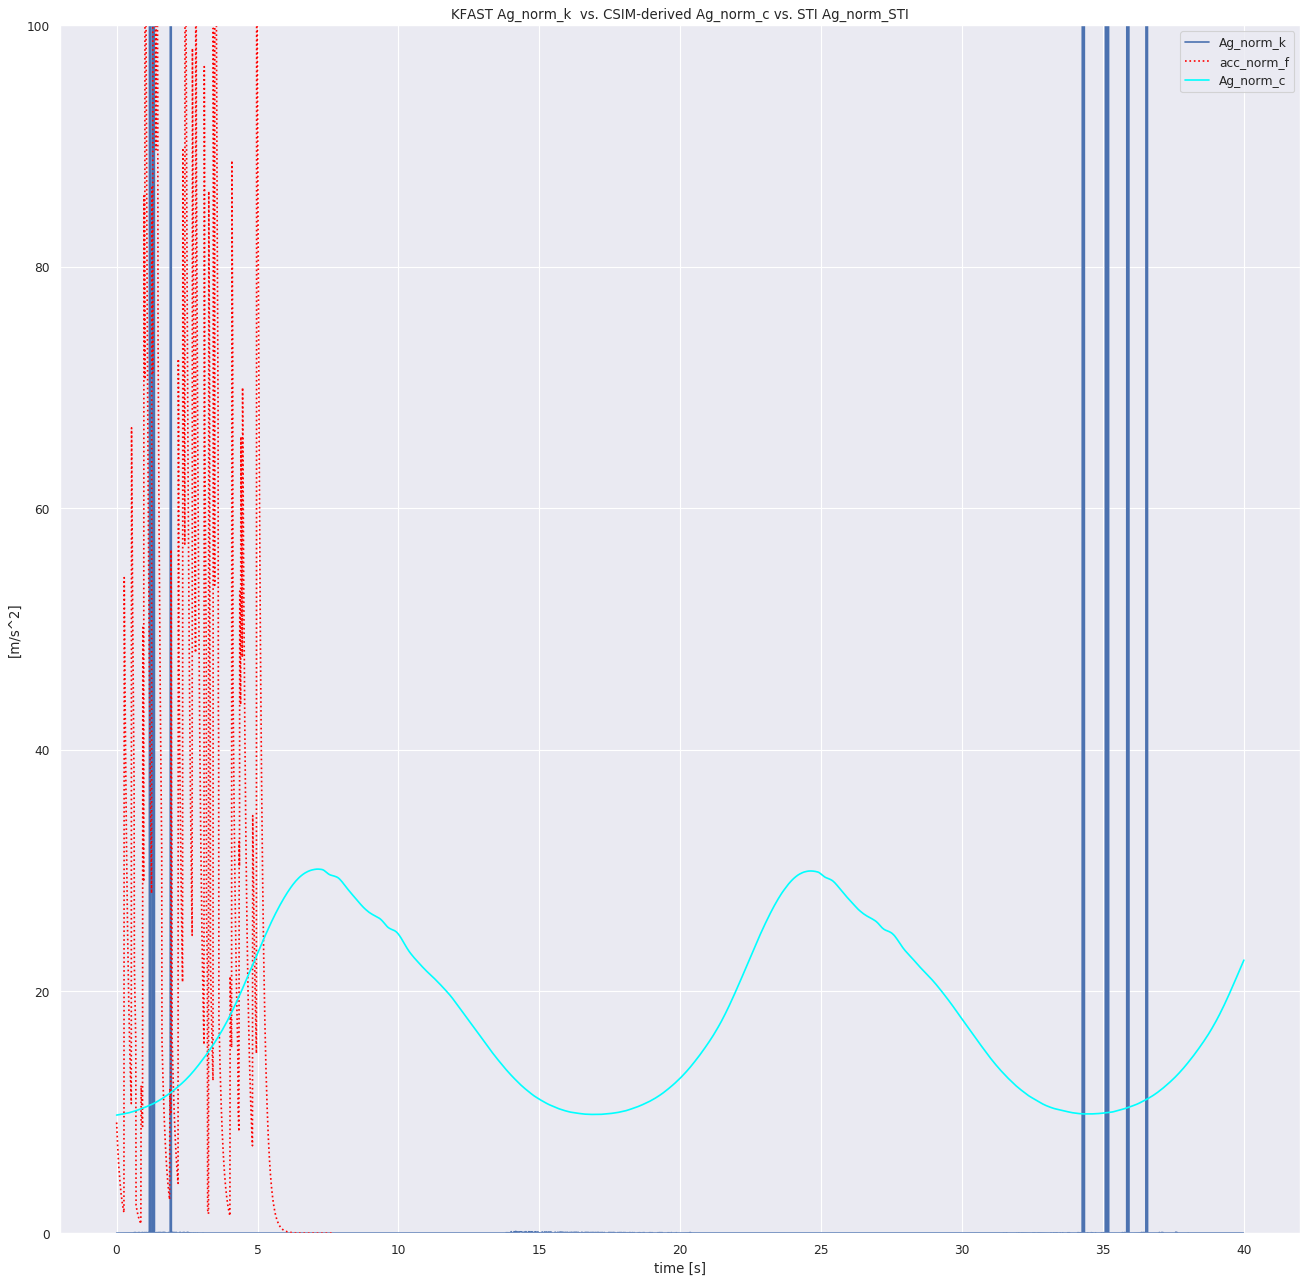

In [345]:
#Plot  filtered  acc_norm_f from STI
if injupyter:
    %matplotlib inline 
#notebook
ax=[None]*2

fig= plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
    
ax.plot(time_k[idx_k],Ag_norm_k,label='Ag_norm_k')
ax.plot(time_STI,Ag_normf_STI,label=STI_Agnorm_f_str,color='red',linestyle=':')
ax.plot(time_c2k,Ag_norm_c,label='Ag_norm_c',color='cyan')

ax.set_xlabel('time [s]')
ax.set_ylabel('[m/s^2]')
ax.set_ylim(0,100)
ax.set_title('KFAST Ag_norm_k  vs. CSIM-derived Ag_norm_c vs. STI Ag_norm_STI')
plt.legend(loc='best')

# -----------------------------------------------------------------------------------------------------

In [346]:
#Attempts at othe rpackages
#import navpy
#from dcm2euler import euler_angles_from_rotation_matrix as dcm2eu
#print(np.rad2deg(dcm2eu(dcm_g2b_c2k[0,:,:])))
#navpy.dcm2angle(dcm_g2b_c2k[0,:,:], rotation_sequence='ZYX',output_unit='deg')
#import PSpincalc
#np.rad2deg(PSpincalc.DCM2EA(dcm_g2b_c2k[0,:,:],'xyz'))